# Generate CSV files for DB creation
**Notebook is complete ETL operation which creates CSV files to be loaded in DB**
* **Merged rt_trips and rt_leavetimes [for JANUARY 2018] data is used for training ML model**
* **Also, website DB is created refering this data for regerence timetables and other metadata related to LINEID- RUTEID - DIRECTION - PROGRAMNUMBER**

In [1]:
import numpy as np
import pandas as pd
from warnings import filterwarnings
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns
filterwarnings('ignore')

<br>
<br>

## read rt_trips_DB_2018.csv
rt_trips_DB_2018.txt consists data for ENTIRE 2018
* Based on priliminary EDA, only following features are preserved while converting trips file into csv<br>
 [DAYOFSERVICE, TRIPID, LINEID, ROUTEID, DIRECTION, PLANNEDTIME_ARR, PLANNEDTIME_DEP, ACTUALTIME_ARR, ACTUALTIME_DEP ]

In [2]:
df_trips = pd.read_csv("../DB/monthlyData/rt_trips_DB_2018.csv",skip_blank_lines=True,index_col=False)

In [3]:
df_trips['DAYOFSERVICE'] = pd.to_datetime(df_trips['DAYOFSERVICE'])
df_trips['TRIPID'] = pd.to_numeric(df_trips['TRIPID'], downcast='integer', errors='coerce')
df_trips['LINEID'] = df_trips['LINEID'].astype('str')
df_trips['ROUTEID'] = df_trips['ROUTEID'].astype('str')
df_trips['DIRECTION'] = pd.to_numeric(df_trips['DIRECTION'], downcast='integer', errors='coerce')
df_trips['PLANNEDTIME_ARR'] = pd.to_numeric(df_trips['PLANNEDTIME_ARR'], downcast='integer', errors='coerce')
df_trips['PLANNEDTIME_DEP'] = pd.to_numeric(df_trips['PLANNEDTIME_DEP'], downcast='integer', errors='coerce')
df_trips['ACTUALTIME_ARR'] = pd.to_numeric(df_trips['ACTUALTIME_ARR'], downcast='integer', errors='coerce')
df_trips['ACTUALTIME_DEP'] = pd.to_numeric(df_trips['ACTUALTIME_DEP'], downcast='integer', errors='coerce')

In [4]:
print("Shape of dataframe",df_trips.shape)
df_trips.head()

Shape of dataframe (2182637, 9)


,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP
0,2018-02-07,6253783,68,68_80,1,87245,84600,87524.0,84600.0
1,2018-02-07,6262138,25B,25B_271,2,30517,26460,32752.0,NaN
2,2018-02-07,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0
3,2018-02-07,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0
4,2018-02-07,6253175,14,14_15,1,85383,81600,84682.0,81608.0


### UNIQUE ENTRIES

In [5]:
df_trips.nunique()

DAYOFSERVICE          360
TRIPID             658964
LINEID                130
ROUTEID               588
DIRECTION               2
PLANNEDTIME_ARR     64461
PLANNEDTIME_DEP       791
ACTUALTIME_ARR      68122
ACTUALTIME_DEP      66771
dtype: int64

<br>
<br>

## read Janury_2018.csv
* rt_leavetimes_DB_2018.txt is of size ~ 11 GB. It is memory expensive to read and anlyze
* Hence it is devided into 1 GB chunks -- resulting into 11 subfiles
* Further, these **1 GB subfiles files are succesively processed to generate seperate files named <month_year.csv> of data for each month**
* Based on priliminary EDA, only following features are preserved while converting trips file into csv<br>
 [DAYOFSERVICE, TRIPID, PROGRNUMBER, STOPPOINTID, PLANNEDTIME_ARR, PLANNEDTIME_DEP, ACTUALTIME_ARR, ACTUALTIME_DEP]

In [6]:
df_Jan = pd.read_csv("../DB/monthlyData/January_2018.csv",skip_blank_lines=True,index_col=False)
df_Jan.drop('VEHICLEID',axis=1,inplace=True)

In [7]:
df_Jan['DAYOFSERVICE'] = pd.to_datetime(df_Jan['DAYOFSERVICE'])
df_Jan['TRIPID'] = pd.to_numeric(df_Jan['TRIPID'], downcast='integer', errors='coerce')
df_Jan['PROGRNUMBER'] = pd.to_numeric(df_Jan['PROGRNUMBER'], downcast='integer', errors='coerce')
df_Jan['STOPPOINTID'] = pd.to_numeric(df_Jan['STOPPOINTID'], downcast='integer', errors='coerce')
df_Jan['PLANNEDTIME_ARR'] = pd.to_numeric(df_Jan['PLANNEDTIME_ARR'], downcast='integer', errors='coerce')
df_Jan['PLANNEDTIME_DEP'] = pd.to_numeric(df_Jan['PLANNEDTIME_DEP'], downcast='integer', errors='coerce')
df_Jan['ACTUALTIME_ARR'] = pd.to_numeric(df_Jan['ACTUALTIME_ARR'], downcast='integer', errors='coerce')
df_Jan['ACTUALTIME_DEP'] = pd.to_numeric(df_Jan['ACTUALTIME_DEP'], downcast='integer', errors='coerce')

In [8]:
print("Shape of dataframe",df_Jan.shape)
df_Jan.head()

Shape of dataframe (10525004, 8)


,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP
0,2018-01-01,5958355,3,1172,23799,23799,23863,23863
1,2018-01-01,5958355,4,1173,23860,23860,23934,24072
2,2018-01-01,5958355,5,1174,23937,23937,24114,24140
3,2018-01-01,5958355,6,1175,24048,24048,24180,24192
4,2018-01-01,5958355,7,15,24130,24130,24227,24257


### Generate list of STOPPOINTIDs listed in January DATABASE

In [9]:
df_Jan_stops = pd.DataFrame(df_Jan['STOPPOINTID'].unique(),columns=['STOPPOINTID'])
df_Jan_stops.to_csv("../DB/stopID.csv",index = False)
del df_Jan_stops

### Filter DATA for presently served DUBLIN BUS STOPS
**Historic data consists many STOPPOINTIDs which no longer exist**  
* **Hence; another python script is written which parses stopID.csv and makes querry to RTPI web API** 
* **It generates a list of presently served Dublin Bus STOPPOINTIDs**  
* **Entries other than these presently served bus stops are ommitted**  

In [10]:
df_presently_served_stops = pd.read_csv('../DB/bus_stop.csv')
list_presently_served_stops = list(df_presently_served_stops["STOPPOINTID"])
df_Jan = df_Jan.loc[df_Jan['STOPPOINTID'].isin(list_presently_served_stops)]

In [11]:
print("Shape of dataframe",df_Jan.shape)
df_Jan.head()

Shape of dataframe (10389094, 8)


,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP
0,2018-01-01,5958355,3,1172,23799,23799,23863,23863
1,2018-01-01,5958355,4,1173,23860,23860,23934,24072
2,2018-01-01,5958355,5,1174,23937,23937,24114,24140
3,2018-01-01,5958355,6,1175,24048,24048,24180,24192
4,2018-01-01,5958355,7,15,24130,24130,24227,24257


### UNIQUE ENTRIES

In [12]:
df_Jan.nunique()

DAYOFSERVICE          31
TRIPID             76453
PROGRNUMBER          103
STOPPOINTID         4601
PLANNEDTIME_ARR    68848
PLANNEDTIME_DEP    68848
ACTUALTIME_ARR     71974
ACTUALTIME_DEP     71953
dtype: int64

<br>
<br>

## Merge df_Jan with df_trips on 'TRIPID'
* Arrival and departure time related features of df_trips give End to End Planned and Atcual timings for trip
* They can be calculated by grouping TRIPID - DAYOFSERVICE data available in leavetimes [i.e df_Jan] dataframe; hence are dropped while making merged datframe

In [13]:
df_Jan_trips = df_Jan.drop_duplicates().merge(df_trips[['DAYOFSERVICE','TRIPID', 'LINEID', 'DIRECTION','ROUTEID']],on=['DAYOFSERVICE','TRIPID']).drop_duplicates()

In [14]:
print("Shape of dataframe",df_Jan_trips.shape)
df_Jan_trips.head()

Shape of dataframe (10389094, 11)


,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
0,2018-01-01,5958355,3,1172,23799,23799,23863,23863,41,1,41_3
1,2018-01-01,5958355,4,1173,23860,23860,23934,24072,41,1,41_3
2,2018-01-01,5958355,5,1174,23937,23937,24114,24140,41,1,41_3
3,2018-01-01,5958355,6,1175,24048,24048,24180,24192,41,1,41_3
4,2018-01-01,5958355,7,15,24130,24130,24227,24257,41,1,41_3


### UNIQUE ENTRIES

In [15]:
df_Jan_trips.nunique()

DAYOFSERVICE          31
TRIPID             76453
PROGRNUMBER          103
STOPPOINTID         4601
PLANNEDTIME_ARR    68848
PLANNEDTIME_DEP    68848
ACTUALTIME_ARR     71974
ACTUALTIME_DEP     71953
LINEID               126
DIRECTION              2
ROUTEID              498
dtype: int64

### Save to CSV

In [16]:
df_Jan_trips.to_csv("../DB/ML/Jan_trips_MERGED.csv",index=False)

### Release RAM used for prior dataframes

In [17]:
del df_Jan
del df_trips

<br>
<br>

## Drop insignificant ROUTEIDS
**From prior EDA; We have obtained source of truth stating that:**
* **For a LINEID; ROUTEIDs and TRIPIDs used for DIFFERENT DIRECTION are mutually exclusive**
* **EVEN FOR ROUTEIDs HAVING SAME DIRECTION; STOPPOINTIDs VISITED ARE DIFFERENT**
* **ROUTEIDs ARE NOT KNOWN TO USER & ROUTEIDs ARE NOT TIMEBOUND i.e. timetable DOES NOT exists to follow a ROUTEID**
* **majority of data for a LINEID is tied with a particular ROUTEID**

**Hence, we can safely drop data for insignificant ROUTEIDs** 

In [18]:
# Uncomment and Run to start operation from current section

# df_Jan_trips = pd.read_csv("../DB/ML/Jan_trips_MERGED.csv")

# df_Jan_trips['DAYOFSERVICE'] = pd.to_datetime(df_Jan_trips['DAYOFSERVICE'])
# df_Jan_trips['TRIPID'] = pd.to_numeric(df_Jan_trips['TRIPID'], downcast='integer', errors='coerce')
# df_Jan_trips['PROGRNUMBER'] = pd.to_numeric(df_Jan_trips['PROGRNUMBER'], downcast='integer', errors='coerce')
# df_Jan_trips['STOPPOINTID'] = pd.to_numeric(df_Jan_trips['STOPPOINTID'], downcast='integer', errors='coerce')
# df_Jan_trips['PLANNEDTIME_ARR'] = pd.to_numeric(df_Jan_trips['PLANNEDTIME_ARR'], downcast='integer', errors='coerce')
# df_Jan_trips['PLANNEDTIME_DEP'] = pd.to_numeric(df_Jan_trips['PLANNEDTIME_DEP'], downcast='integer', errors='coerce')
# df_Jan_trips['ACTUALTIME_ARR'] = pd.to_numeric(df_Jan_trips['ACTUALTIME_ARR'], downcast='integer', errors='coerce')
# df_Jan_trips['ACTUALTIME_DEP'] = pd.to_numeric(df_Jan_trips['ACTUALTIME_DEP'], downcast='integer', errors='coerce')
# df_Jan_trips['LINEID'] = df_Jan_trips['LINEID'].astype('str')
# df_Jan_trips['ROUTEID'] = df_Jan_trips['ROUTEID'].astype('str')
# df_Jan_trips['DIRECTION'] = pd.to_numeric(df_Jan_trips['DIRECTION'], downcast='integer', errors='coerce')

### Check distribution for each ROUTEID of each LINEID
**From above evaluation; we do not find definite titmetable is observed to operate a specific ROUTEID**
* **Hence, we need to consider data from specific ROUTEID only and drop the rest**
* **Before taking the step, we should ensure that:**
    * **There exists a dominant ROUTEID for either direction of LINEID**

error in line 41A direction 1
error in line 77X direction 1
error in line 51X direction 1
error in line 46E direction 1
error in line 118 direction 1
error in line 68X direction 1


<Figure size 432x288 with 0 Axes>

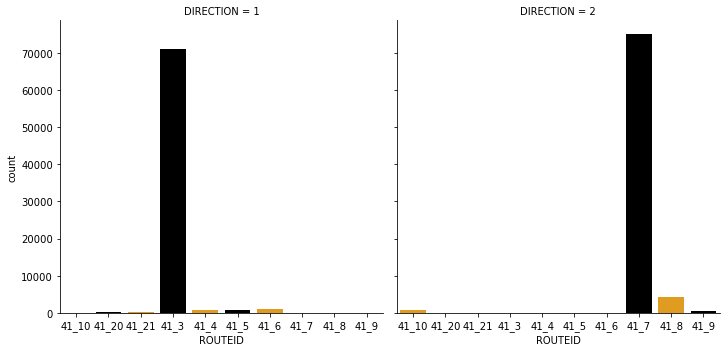

<Figure size 432x288 with 0 Axes>

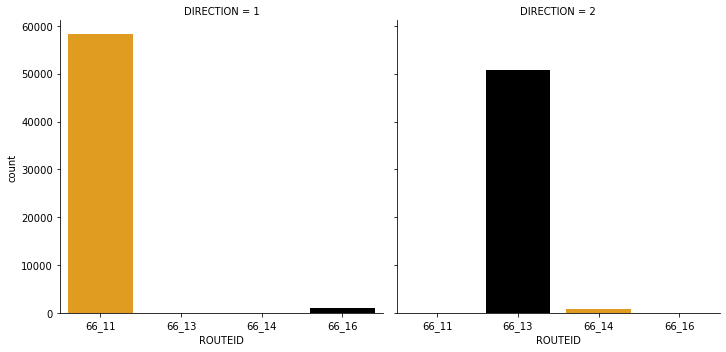

<Figure size 432x288 with 0 Axes>

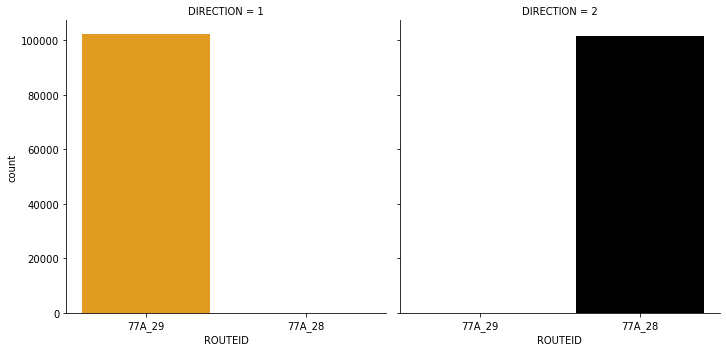

<Figure size 432x288 with 0 Axes>

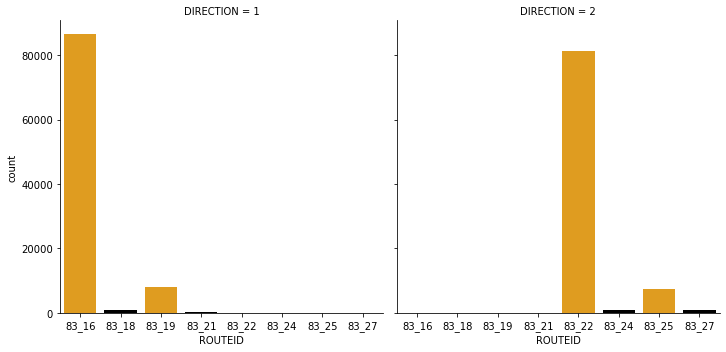

<Figure size 432x288 with 0 Axes>

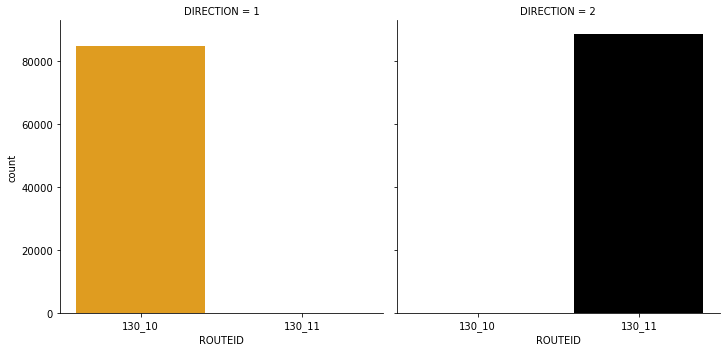

<Figure size 432x288 with 0 Axes>

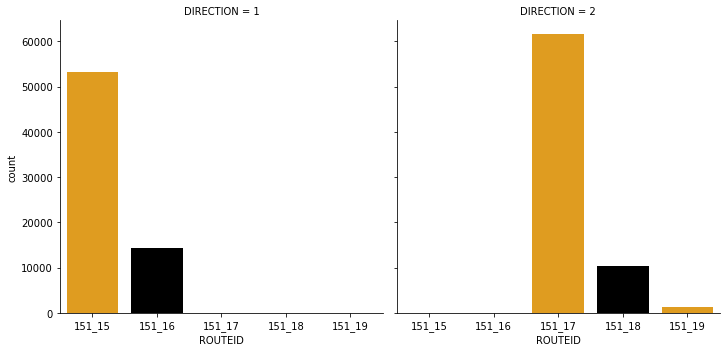

<Figure size 432x288 with 0 Axes>

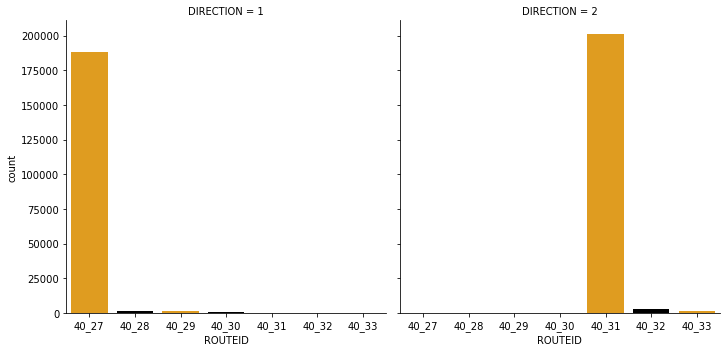

<Figure size 432x288 with 0 Axes>

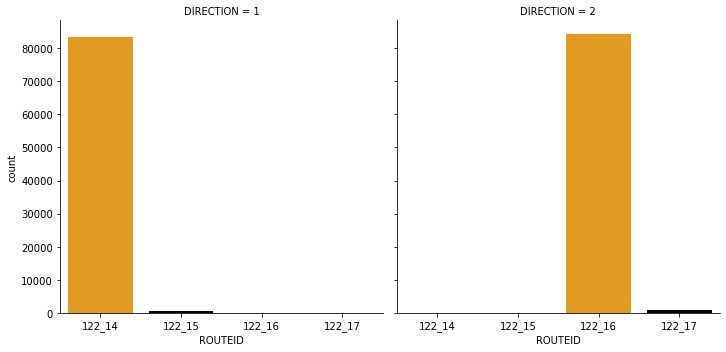

<Figure size 432x288 with 0 Axes>

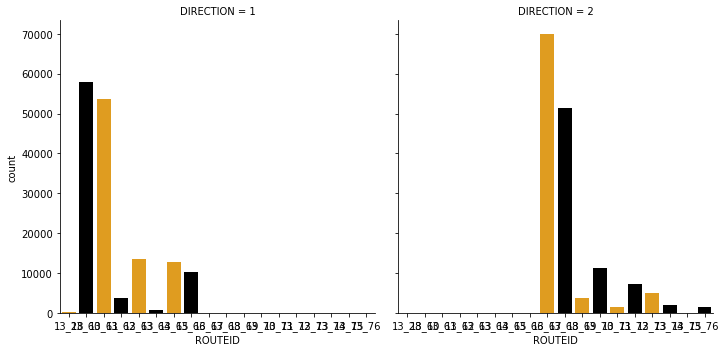

<Figure size 432x288 with 0 Axes>

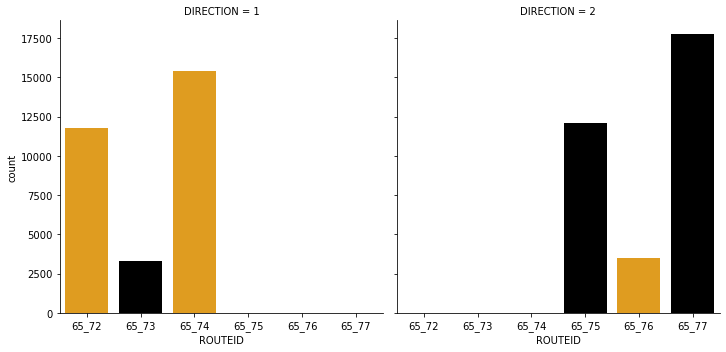

<Figure size 432x288 with 0 Axes>

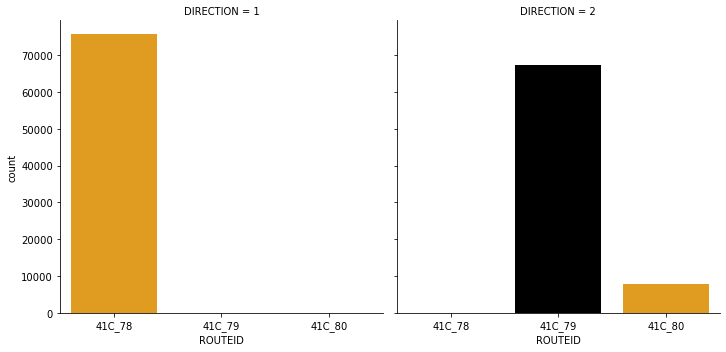

<Figure size 432x288 with 0 Axes>

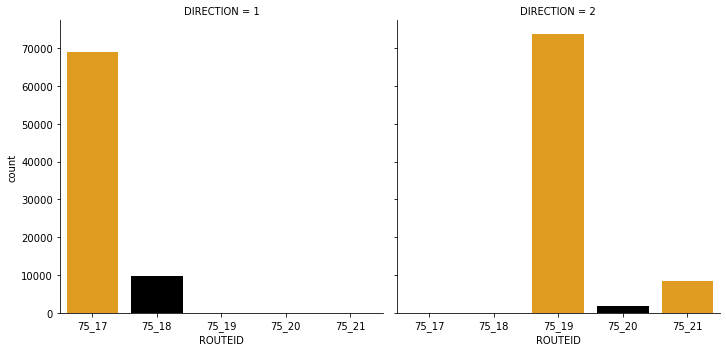

<Figure size 432x288 with 0 Axes>

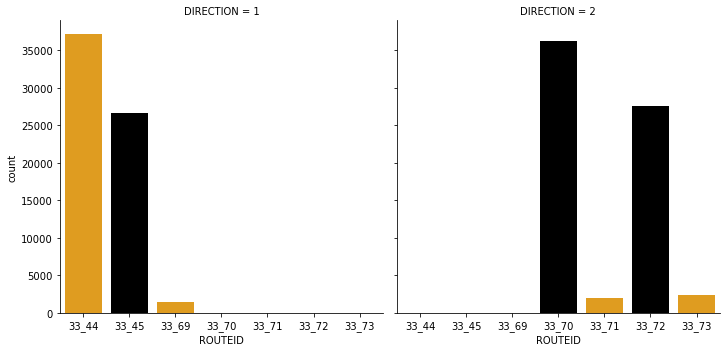

<Figure size 432x288 with 0 Axes>

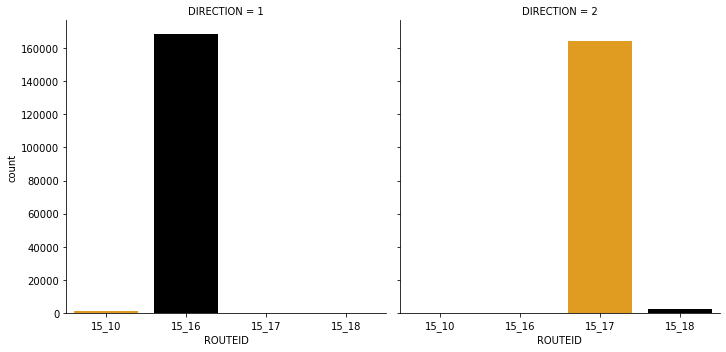

<Figure size 432x288 with 0 Axes>

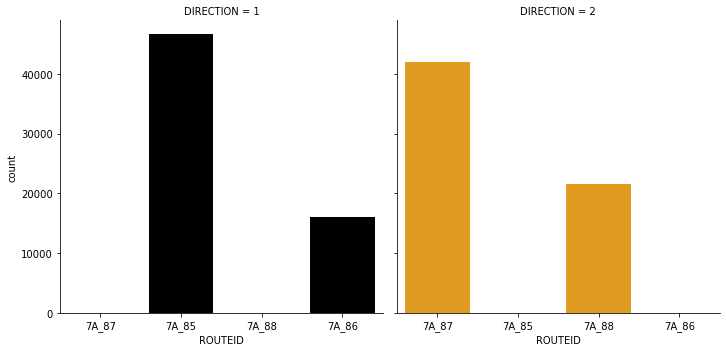

<Figure size 432x288 with 0 Axes>

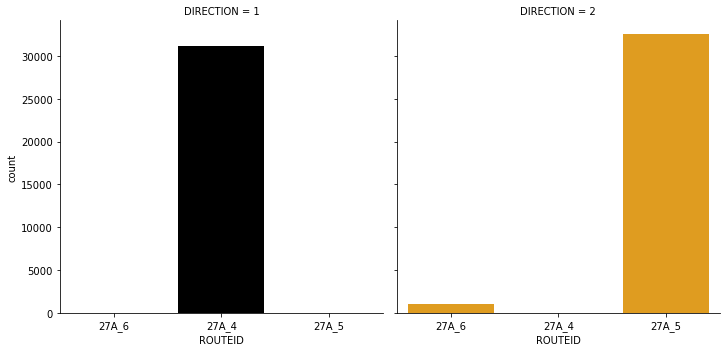

<Figure size 432x288 with 0 Axes>

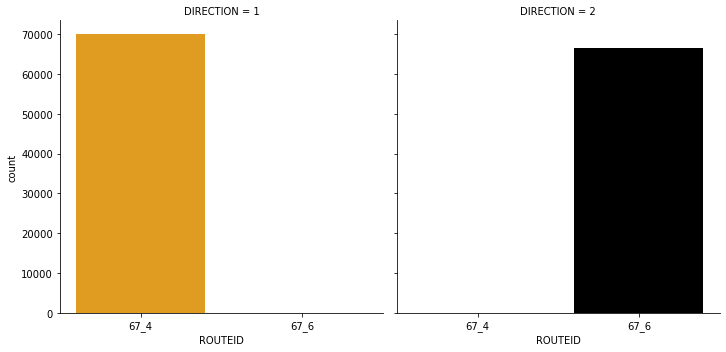

<Figure size 432x288 with 0 Axes>

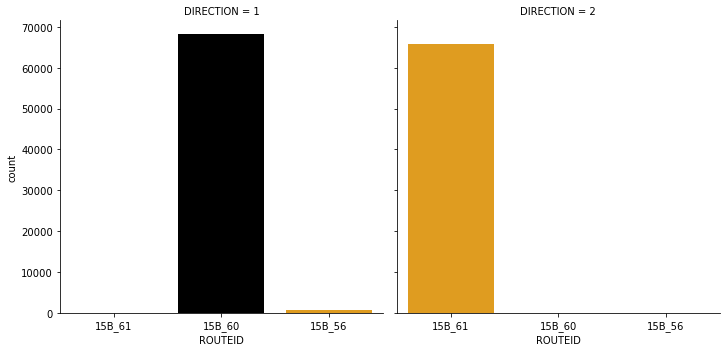

<Figure size 432x288 with 0 Axes>

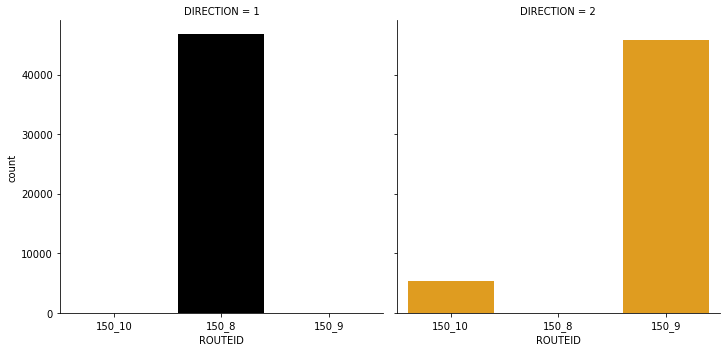

<Figure size 432x288 with 0 Axes>

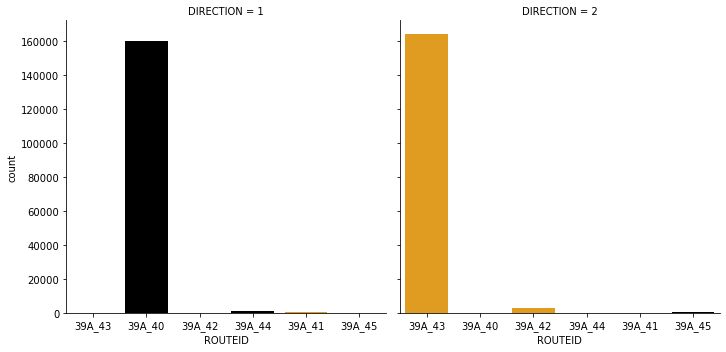

<Figure size 432x288 with 0 Axes>

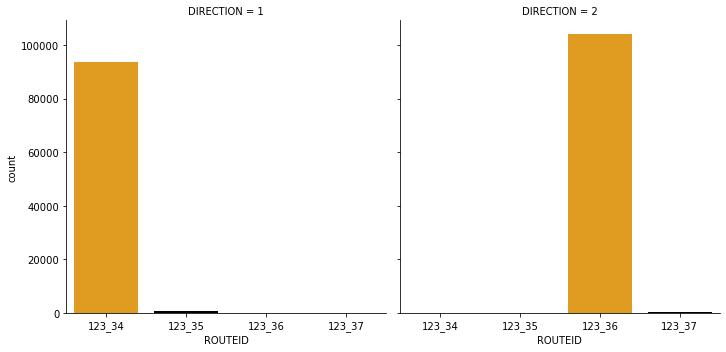

<Figure size 432x288 with 0 Axes>

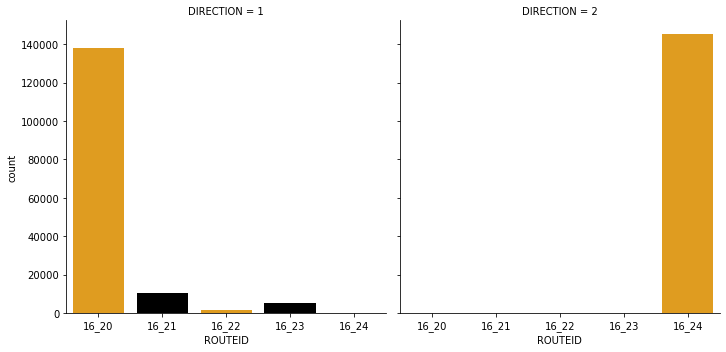

<Figure size 432x288 with 0 Axes>

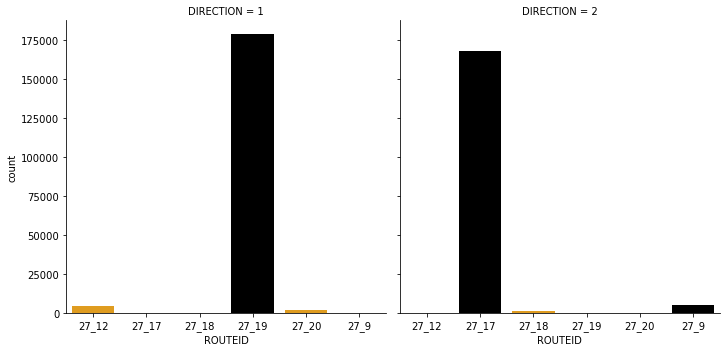

<Figure size 432x288 with 0 Axes>

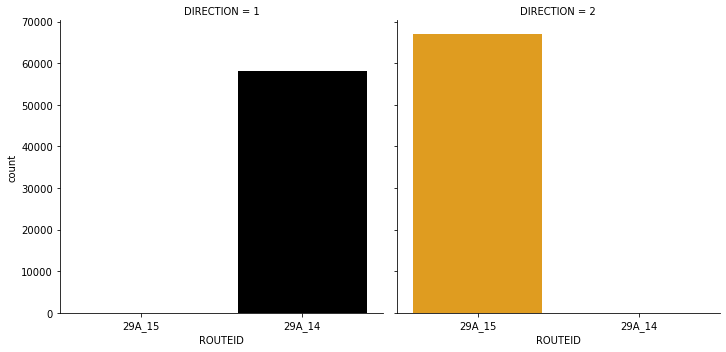

<Figure size 432x288 with 0 Axes>

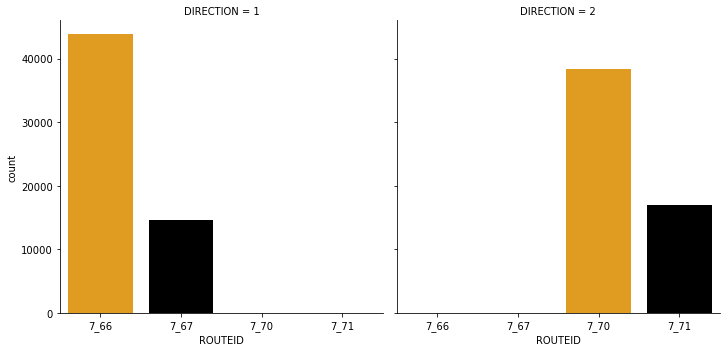

<Figure size 432x288 with 0 Axes>

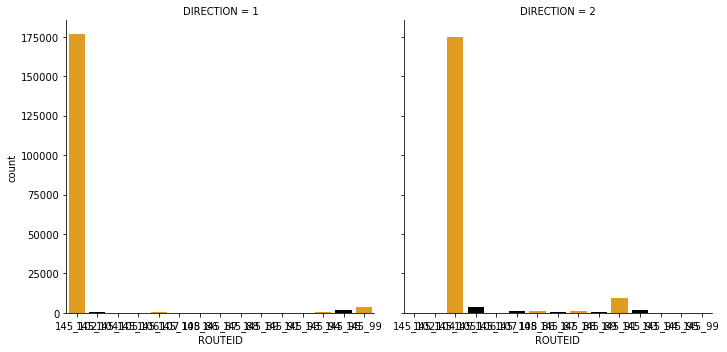

<Figure size 432x288 with 0 Axes>

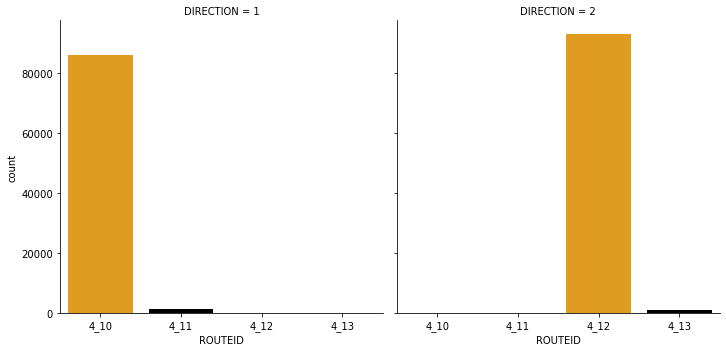

<Figure size 432x288 with 0 Axes>

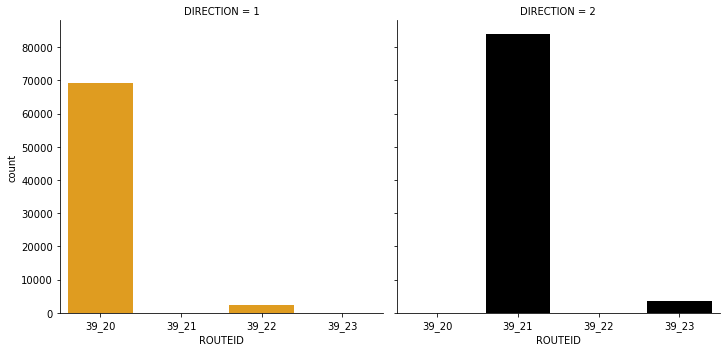

<Figure size 432x288 with 0 Axes>

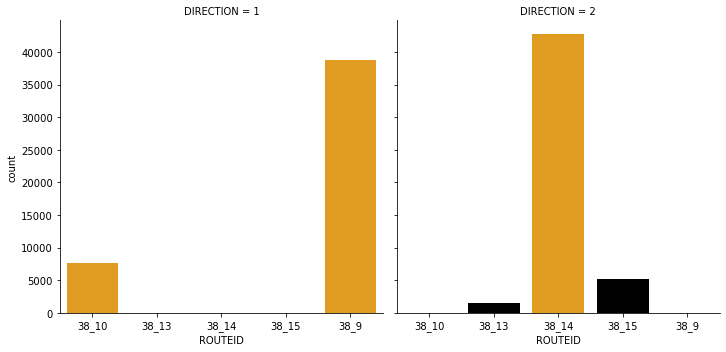

<Figure size 432x288 with 0 Axes>

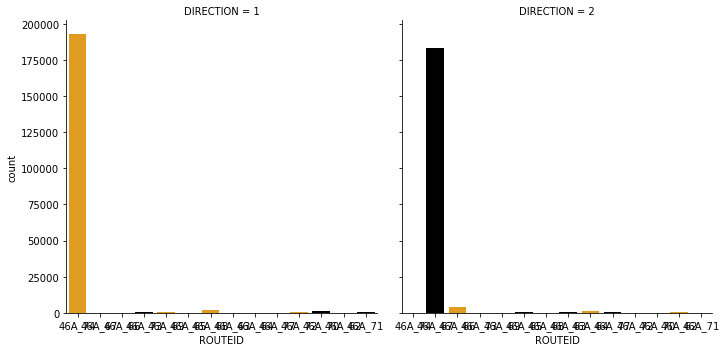

<Figure size 432x288 with 0 Axes>

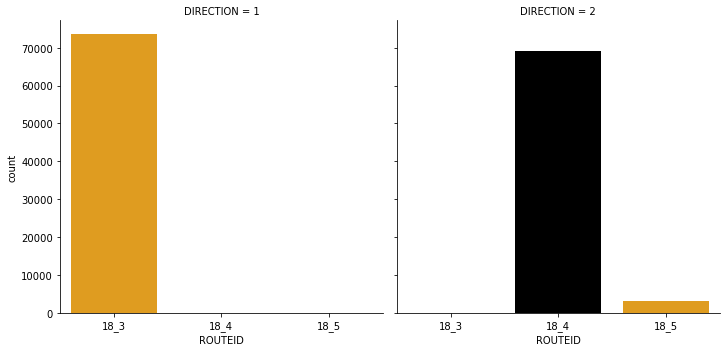

<Figure size 432x288 with 0 Axes>

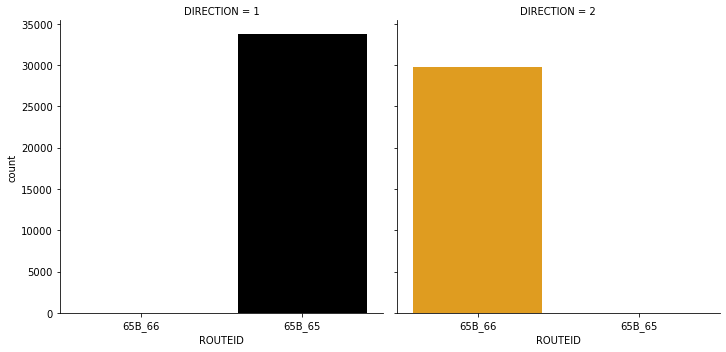

<Figure size 432x288 with 0 Axes>

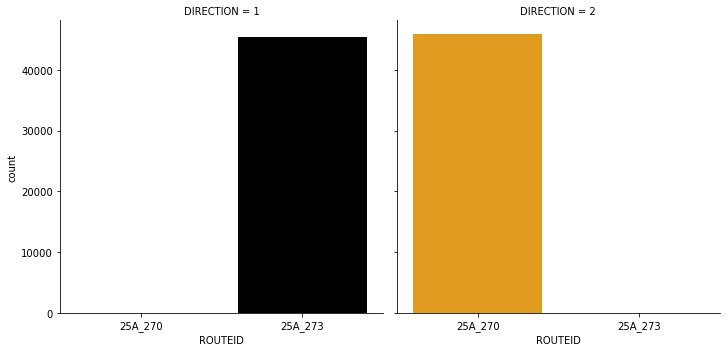

<Figure size 432x288 with 0 Axes>

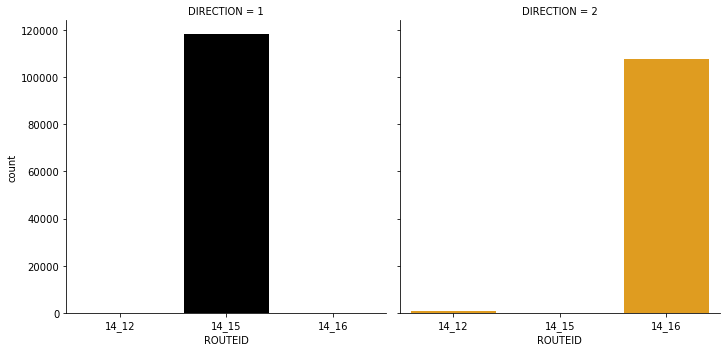

<Figure size 432x288 with 0 Axes>

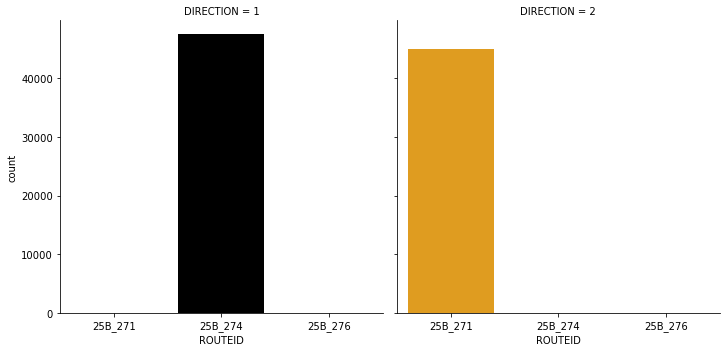

<Figure size 432x288 with 0 Axes>

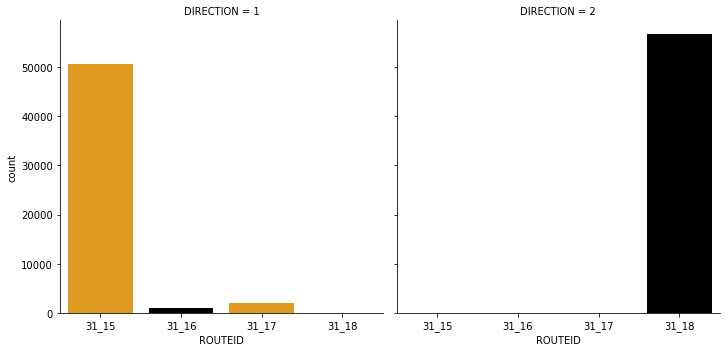

<Figure size 432x288 with 0 Axes>

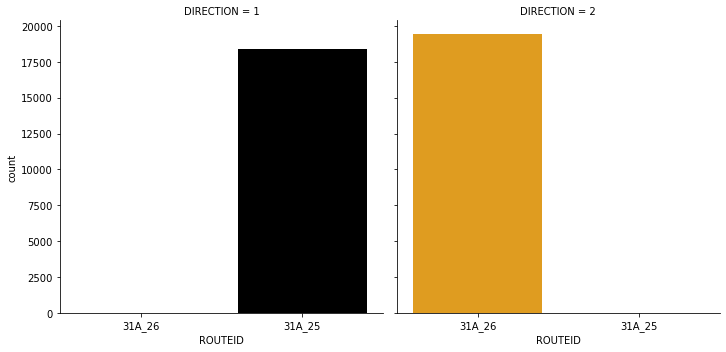

<Figure size 432x288 with 0 Axes>

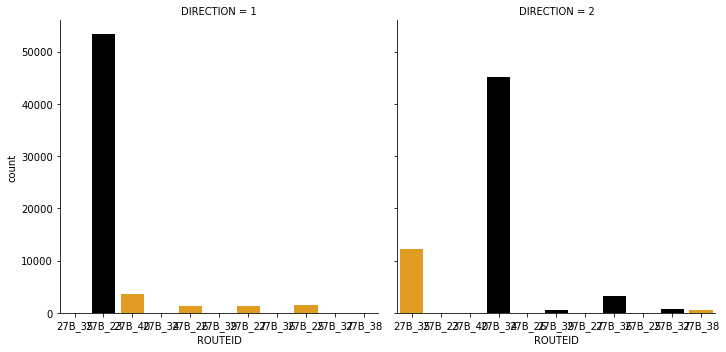

<Figure size 432x288 with 0 Axes>

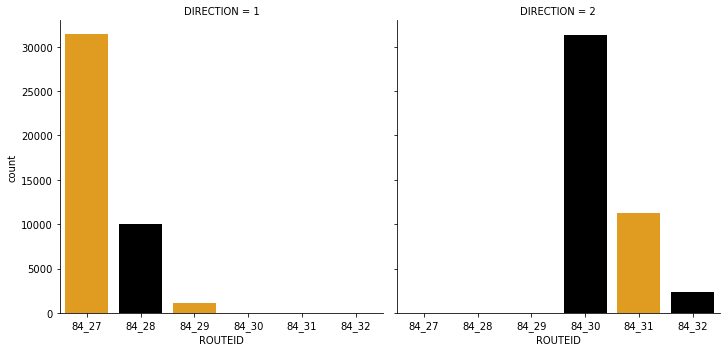

<Figure size 432x288 with 0 Axes>

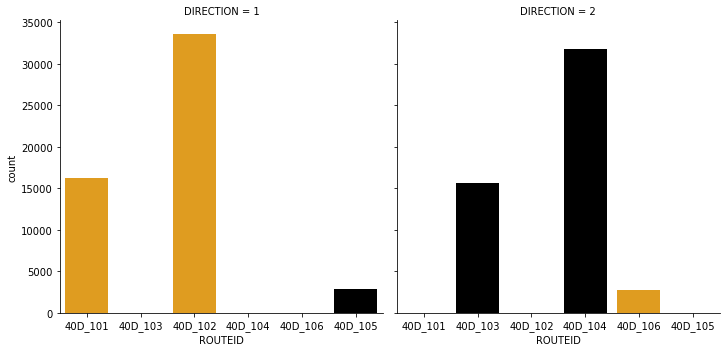

<Figure size 432x288 with 0 Axes>

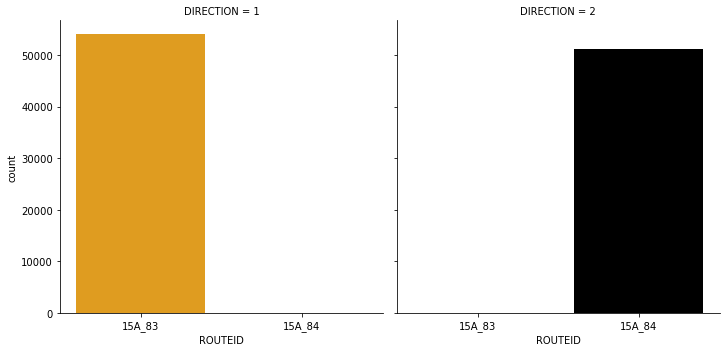

<Figure size 432x288 with 0 Axes>

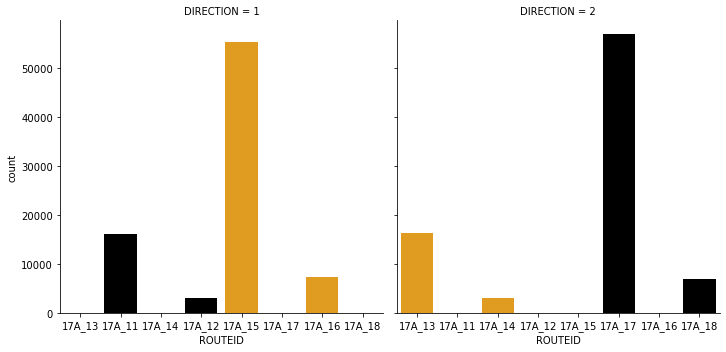

<Figure size 432x288 with 0 Axes>

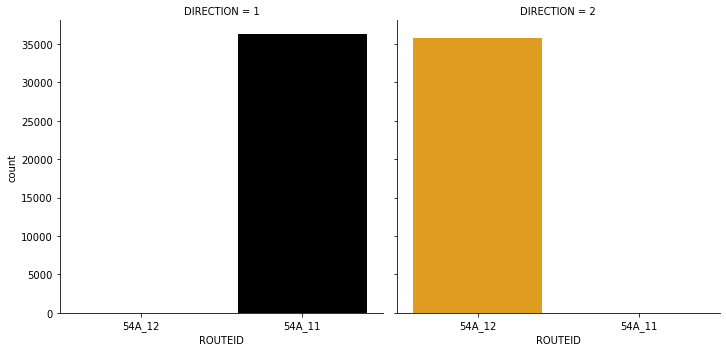

<Figure size 432x288 with 0 Axes>

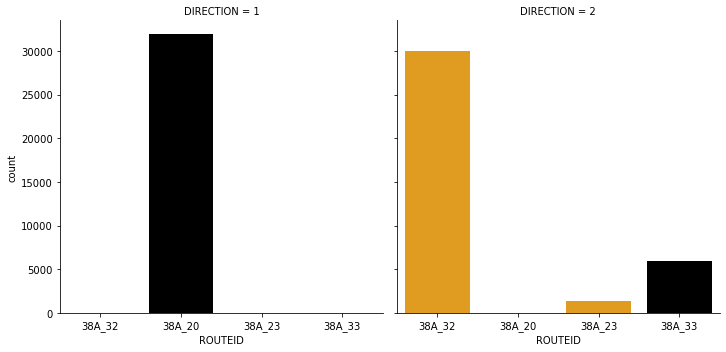

<Figure size 432x288 with 0 Axes>

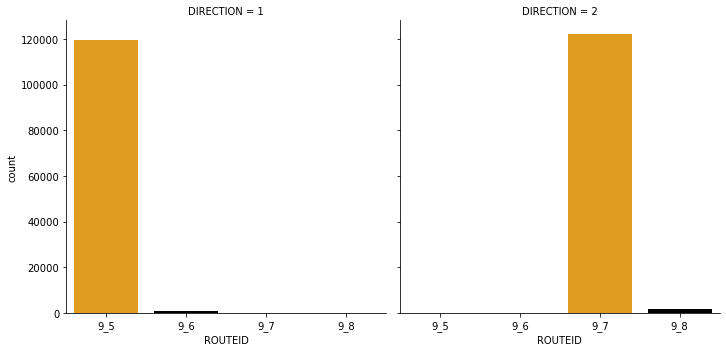

<Figure size 432x288 with 0 Axes>

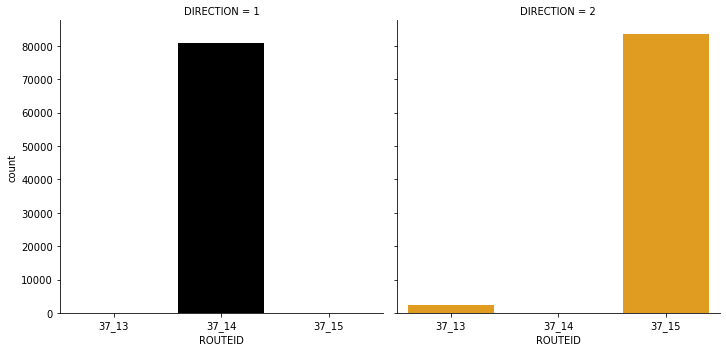

<Figure size 432x288 with 0 Axes>

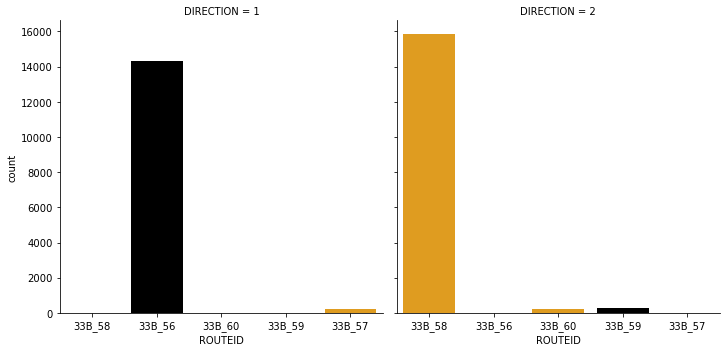

<Figure size 432x288 with 0 Axes>

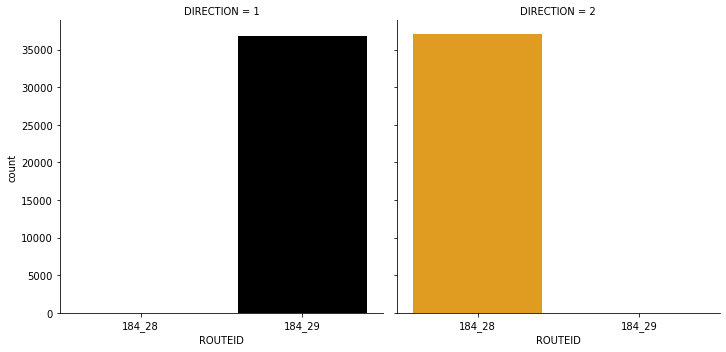

<Figure size 432x288 with 0 Axes>

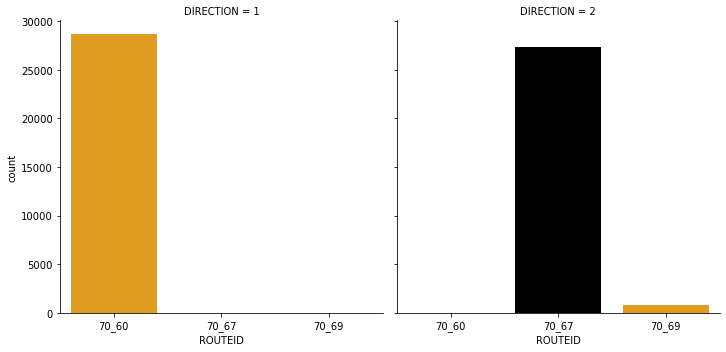

<Figure size 432x288 with 0 Axes>

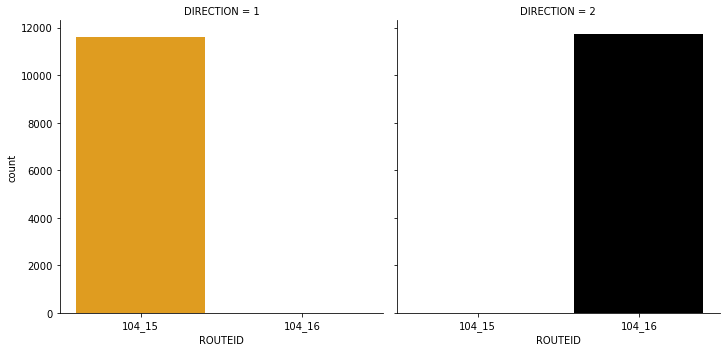

<Figure size 432x288 with 0 Axes>

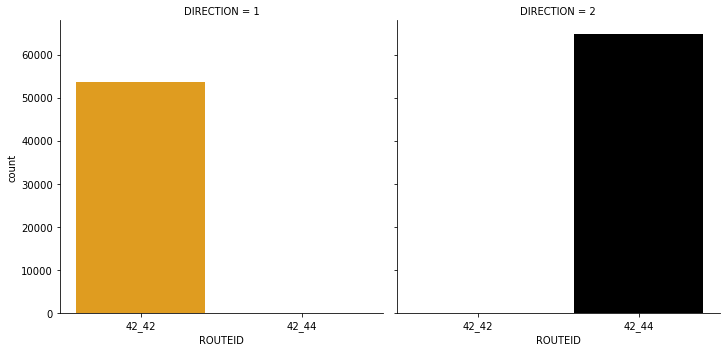

<Figure size 432x288 with 0 Axes>

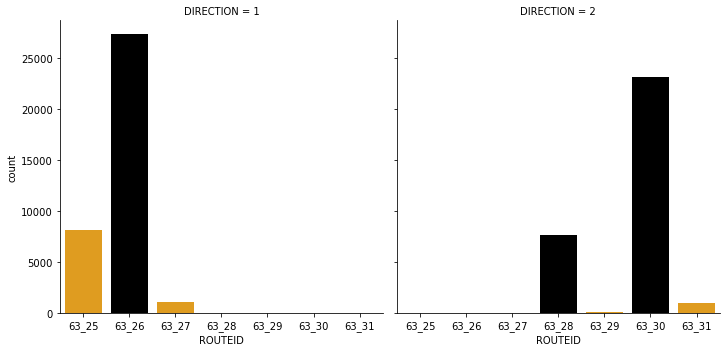

<Figure size 432x288 with 0 Axes>

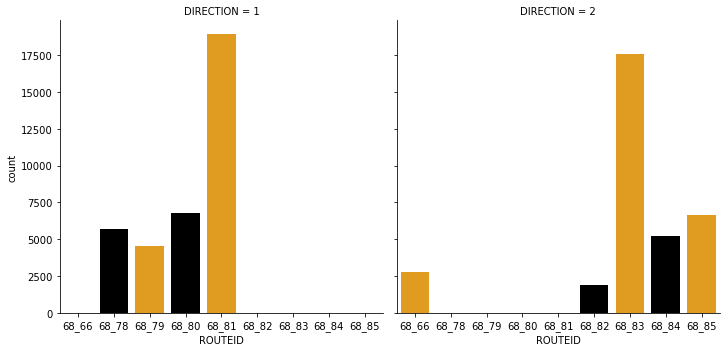

<Figure size 432x288 with 0 Axes>

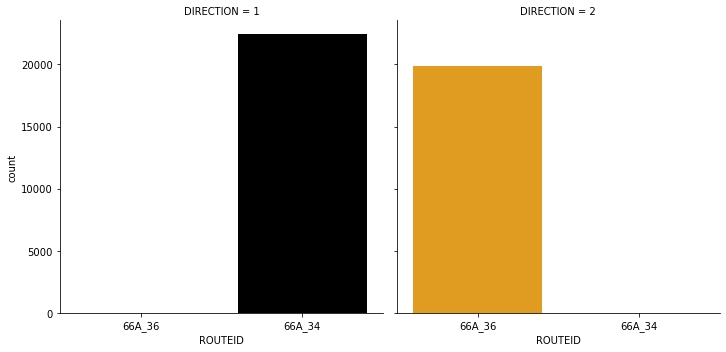

<Figure size 432x288 with 0 Axes>

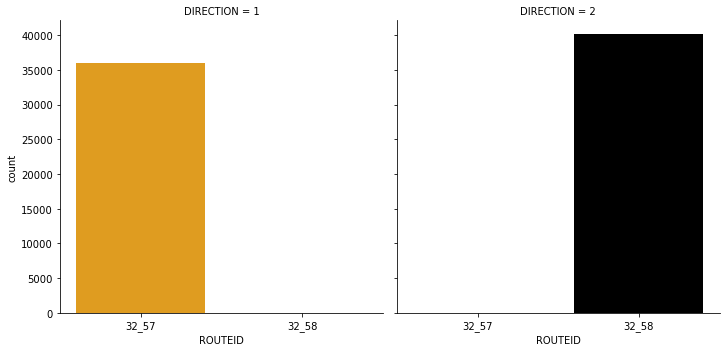

<Figure size 432x288 with 0 Axes>

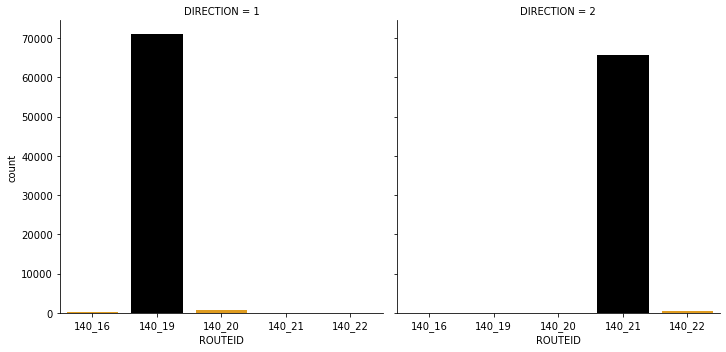

<Figure size 432x288 with 0 Axes>

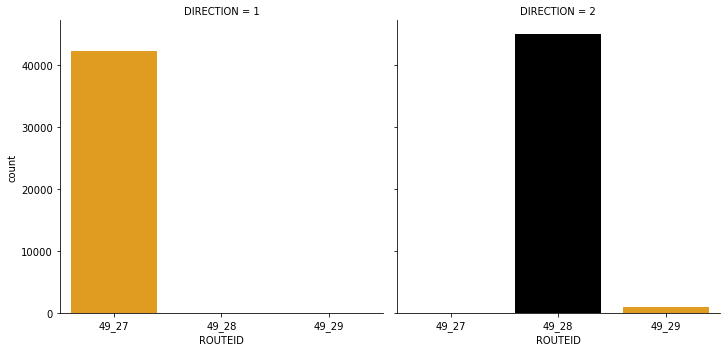

<Figure size 432x288 with 0 Axes>

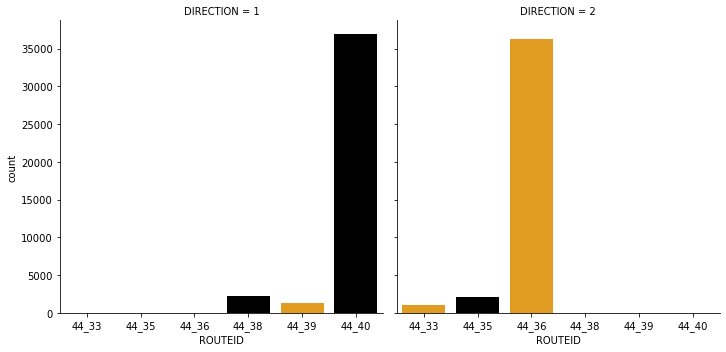

<Figure size 432x288 with 0 Axes>

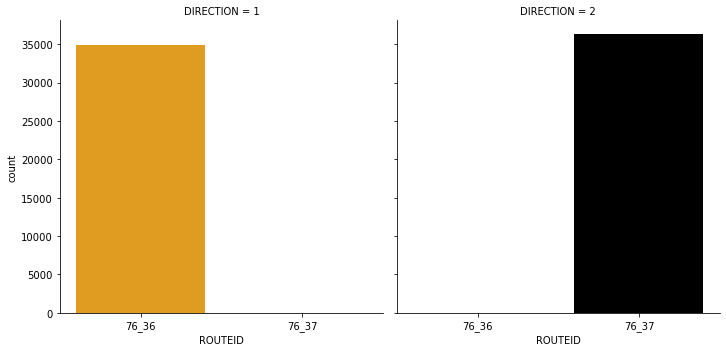

<Figure size 432x288 with 0 Axes>

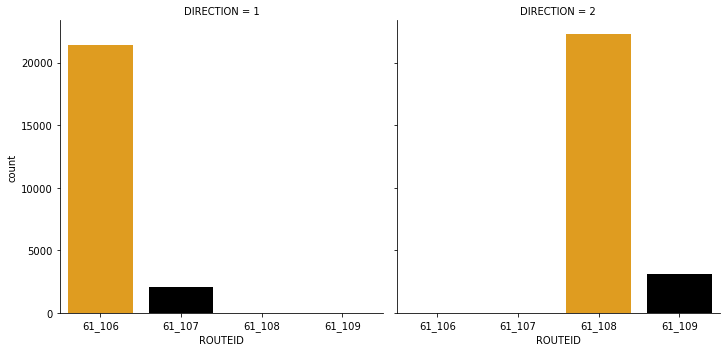

<Figure size 432x288 with 0 Axes>

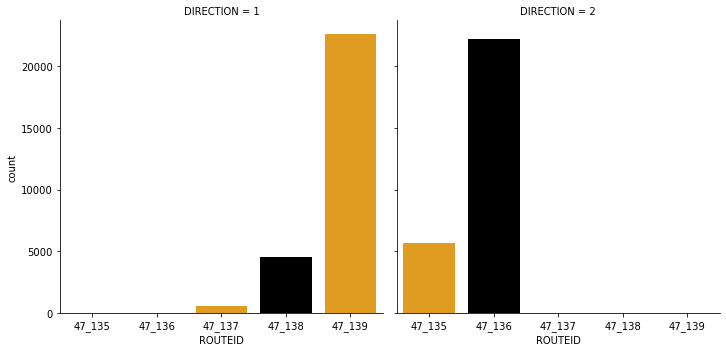

<Figure size 432x288 with 0 Axes>

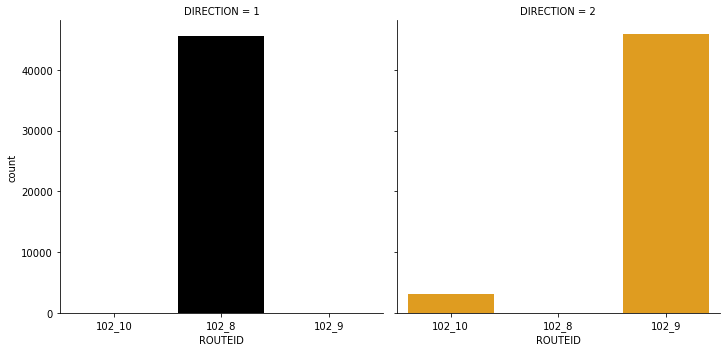

<Figure size 432x288 with 0 Axes>

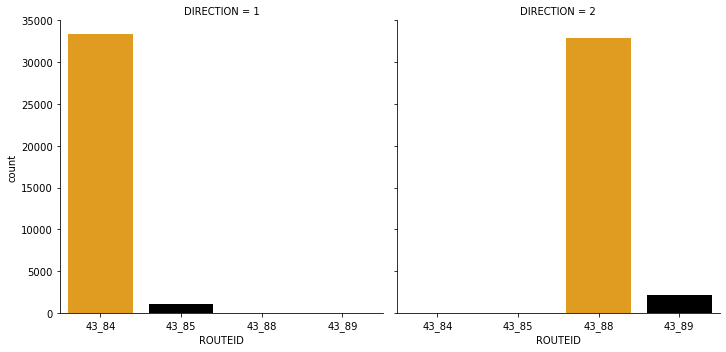

<Figure size 432x288 with 0 Axes>

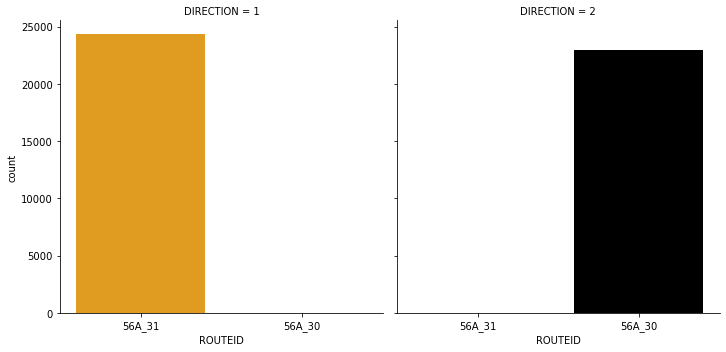

<Figure size 432x288 with 0 Axes>

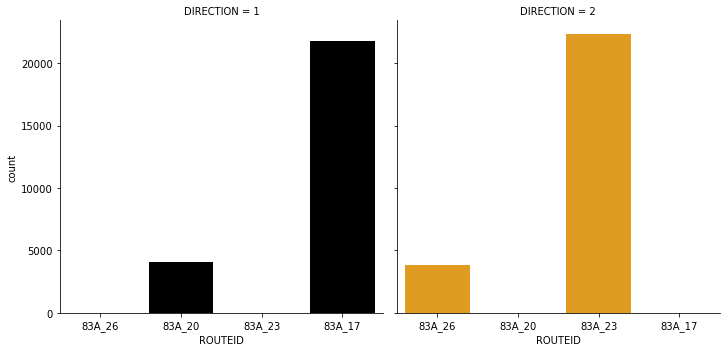

<Figure size 432x288 with 0 Axes>

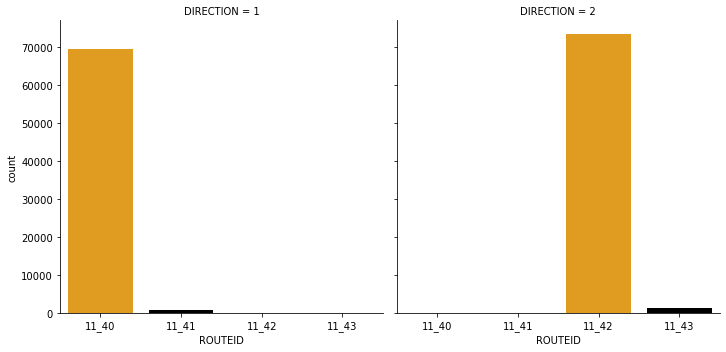

<Figure size 432x288 with 0 Axes>

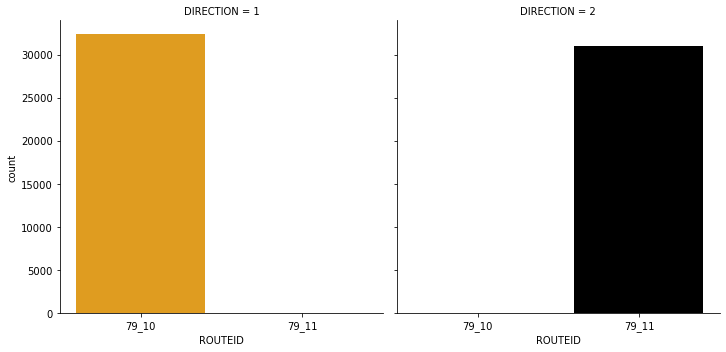

<Figure size 432x288 with 0 Axes>

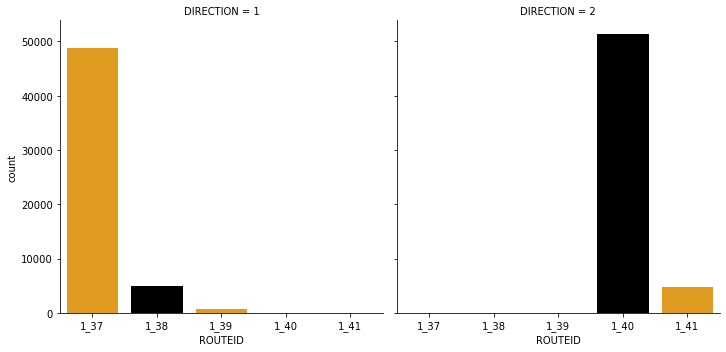

<Figure size 432x288 with 0 Axes>

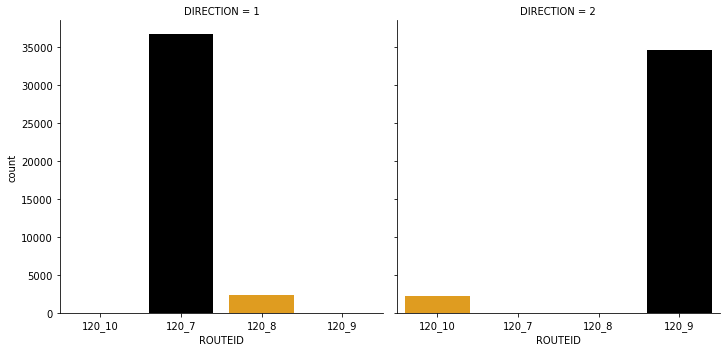

<Figure size 432x288 with 0 Axes>

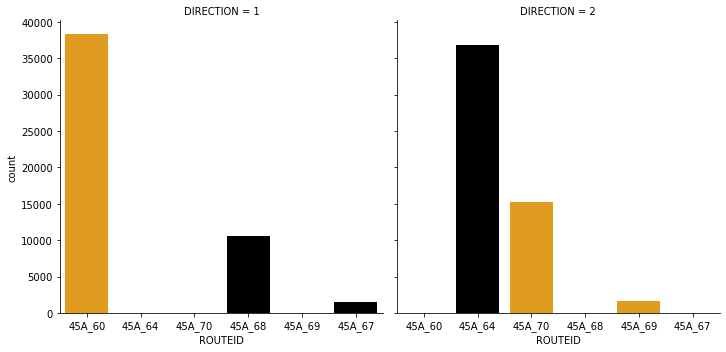

<Figure size 432x288 with 0 Axes>

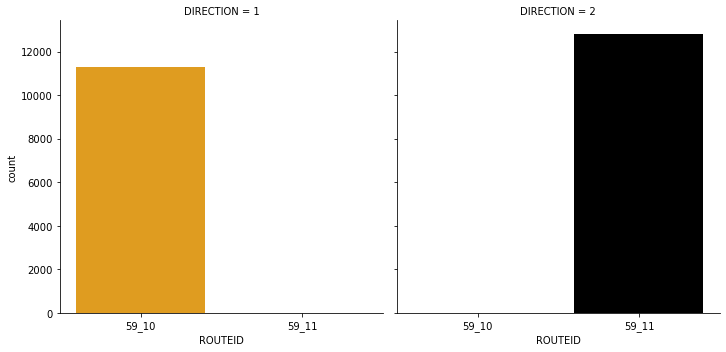

<Figure size 432x288 with 0 Axes>

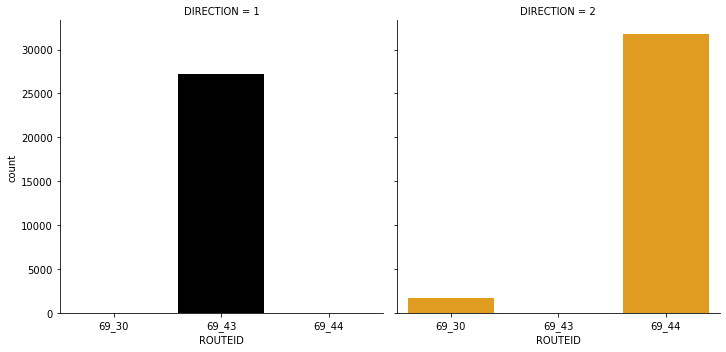

<Figure size 432x288 with 0 Axes>

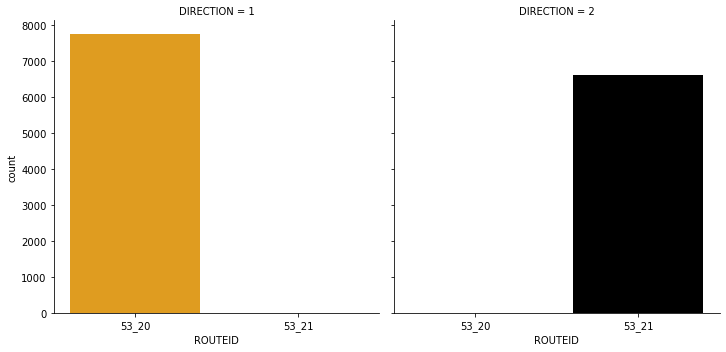

<Figure size 432x288 with 0 Axes>

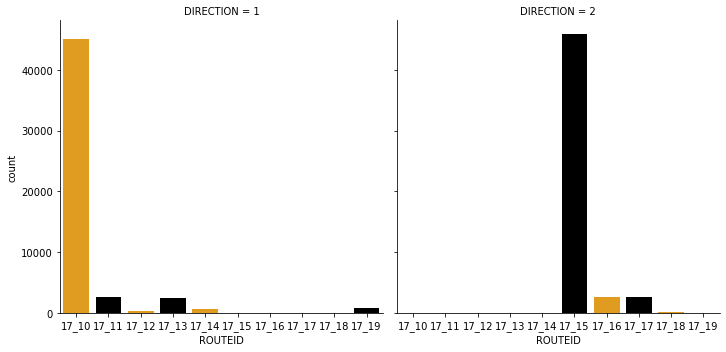

<Figure size 432x288 with 0 Axes>

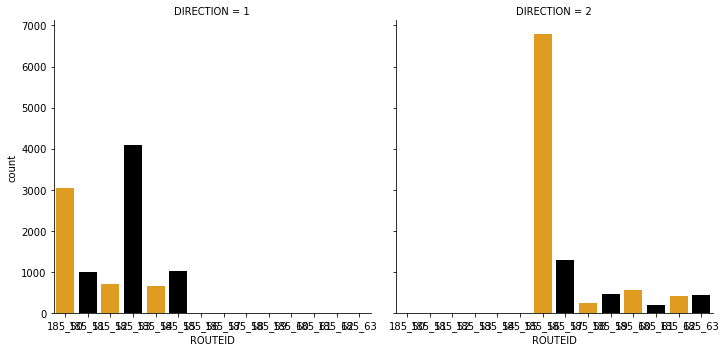

<Figure size 432x288 with 0 Axes>

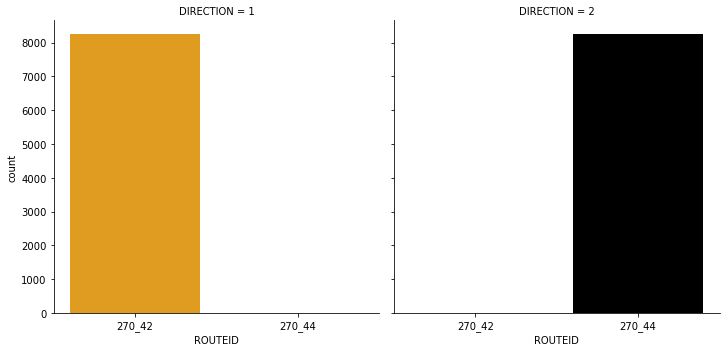

<Figure size 432x288 with 0 Axes>

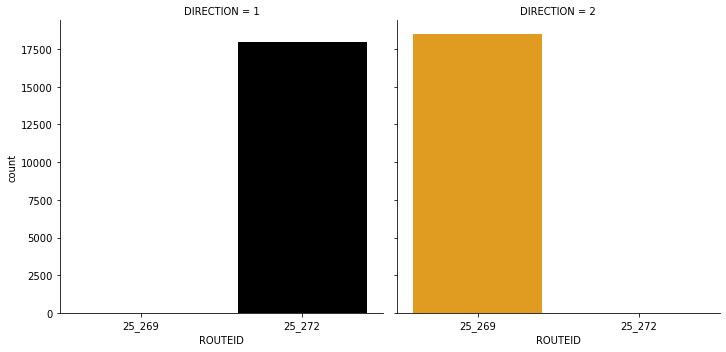

<Figure size 432x288 with 0 Axes>

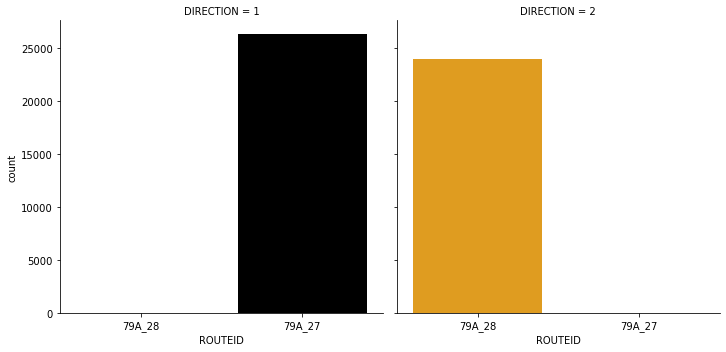

<Figure size 432x288 with 0 Axes>

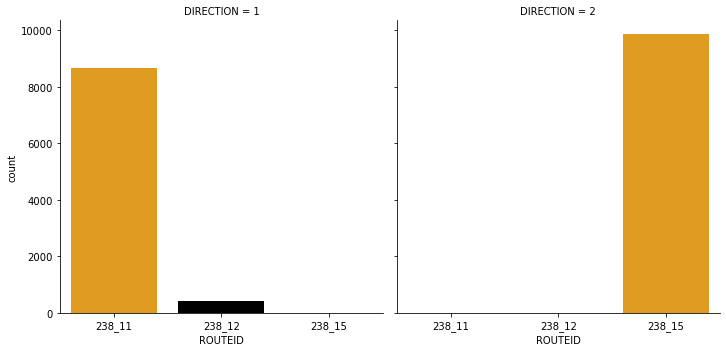

<Figure size 432x288 with 0 Axes>

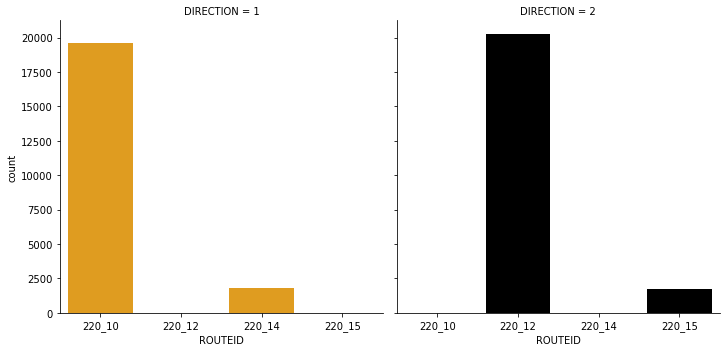

<Figure size 432x288 with 0 Axes>

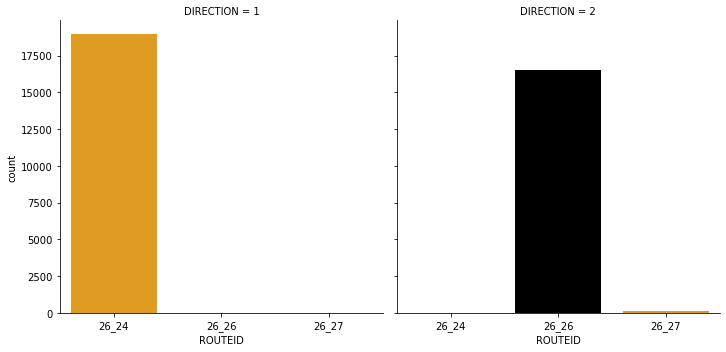

<Figure size 432x288 with 0 Axes>

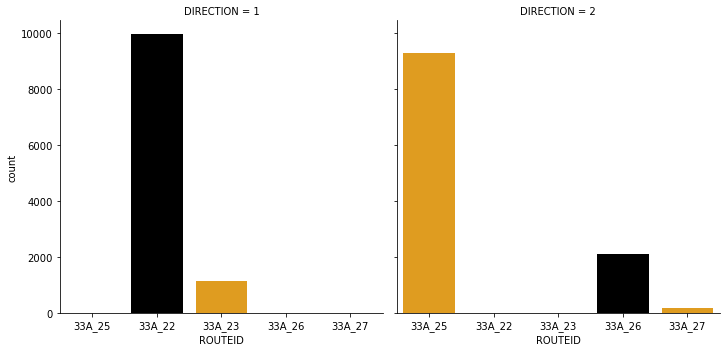

<Figure size 432x288 with 0 Axes>

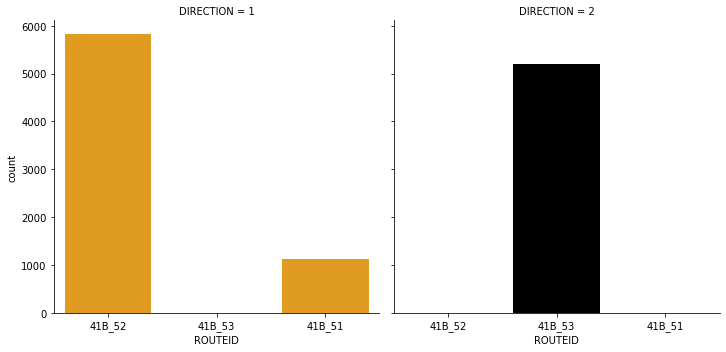

<Figure size 432x288 with 0 Axes>

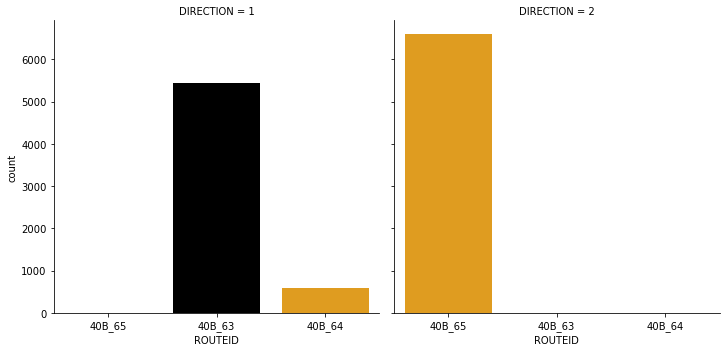

<Figure size 432x288 with 0 Axes>

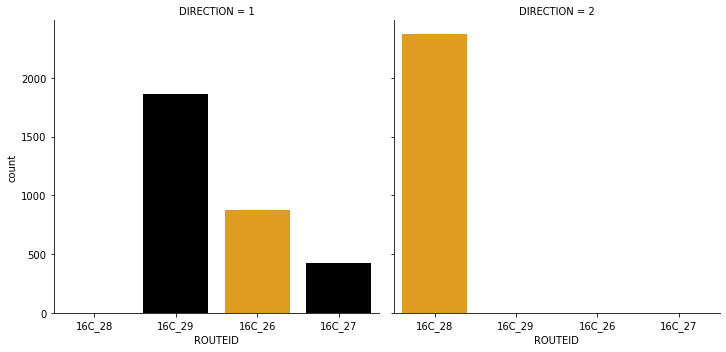

<Figure size 432x288 with 0 Axes>

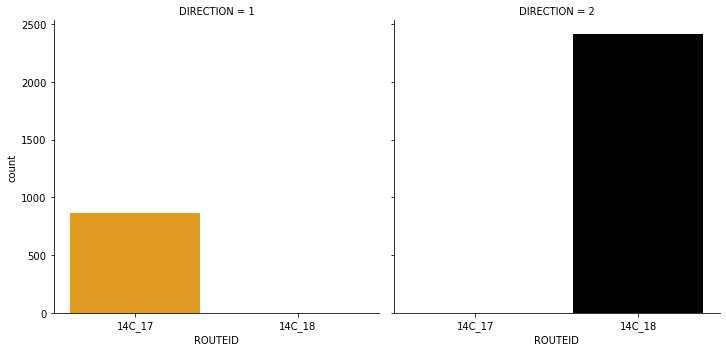

<Figure size 432x288 with 0 Axes>

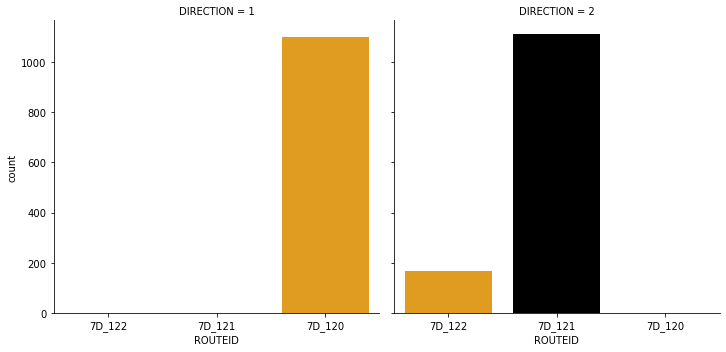

<Figure size 432x288 with 0 Axes>

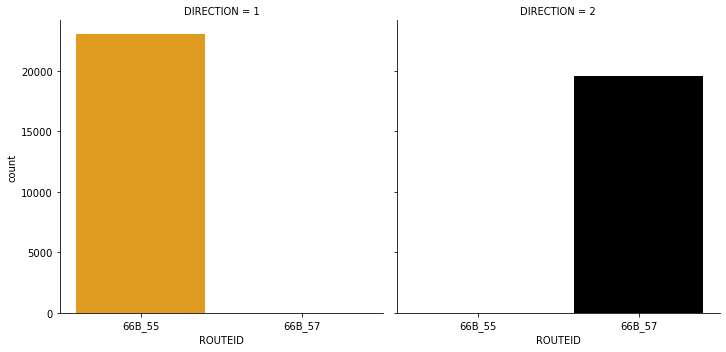

<Figure size 432x288 with 0 Axes>

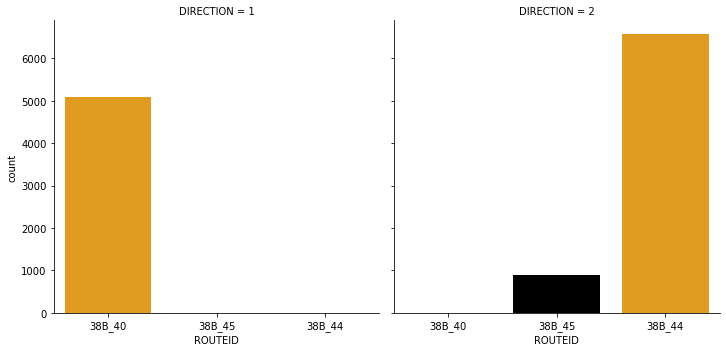

<Figure size 432x288 with 0 Axes>

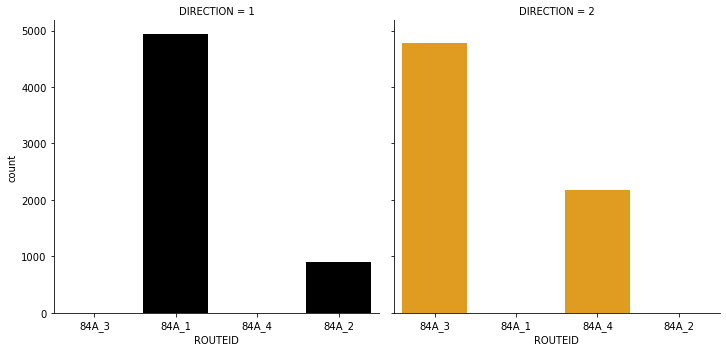

<Figure size 432x288 with 0 Axes>

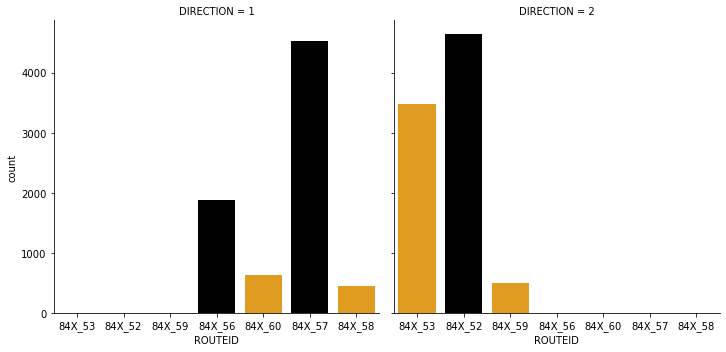

<Figure size 432x288 with 0 Axes>

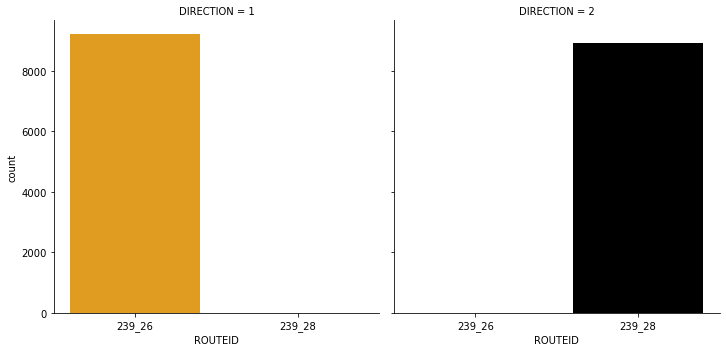

<Figure size 432x288 with 0 Axes>

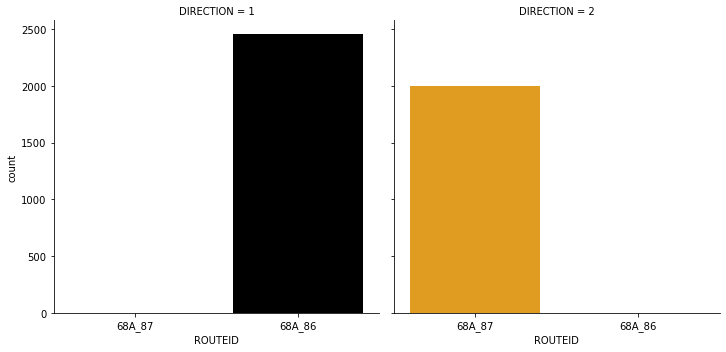

<Figure size 432x288 with 0 Axes>

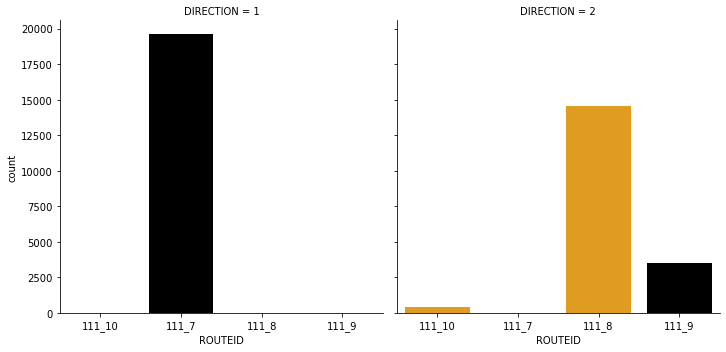

<Figure size 432x288 with 0 Axes>

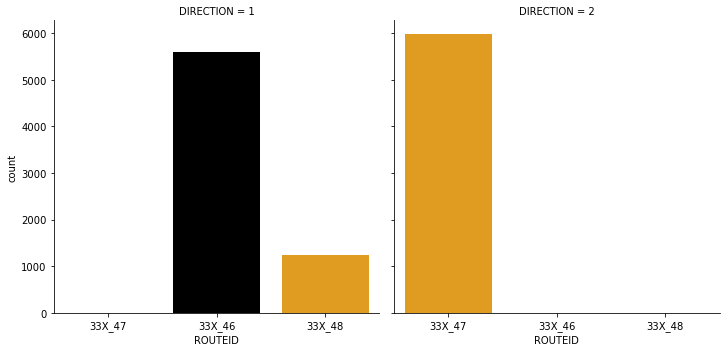

<Figure size 432x288 with 0 Axes>

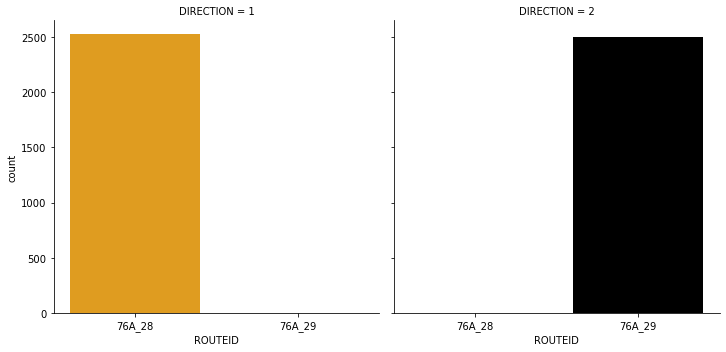

<Figure size 432x288 with 0 Axes>

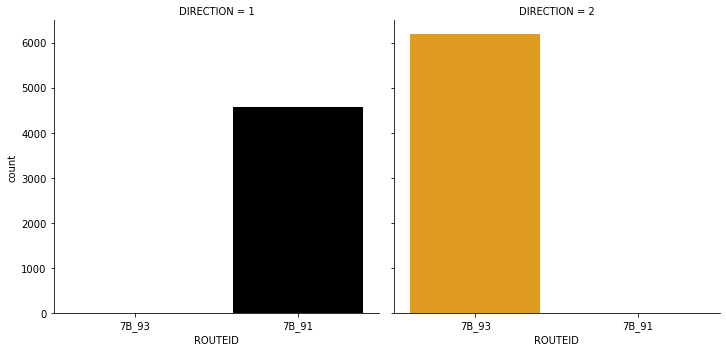

<Figure size 432x288 with 0 Axes>

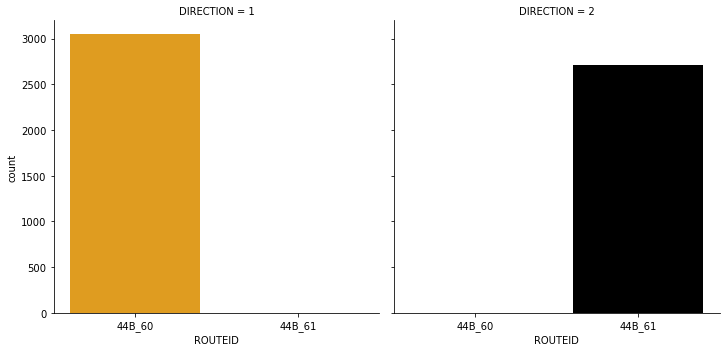

<Figure size 432x288 with 0 Axes>

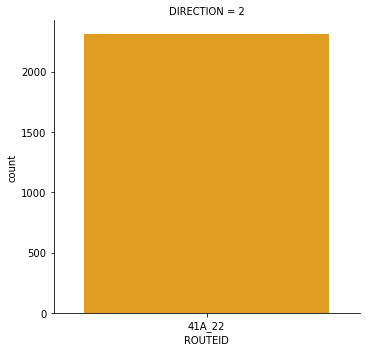

<Figure size 432x288 with 0 Axes>

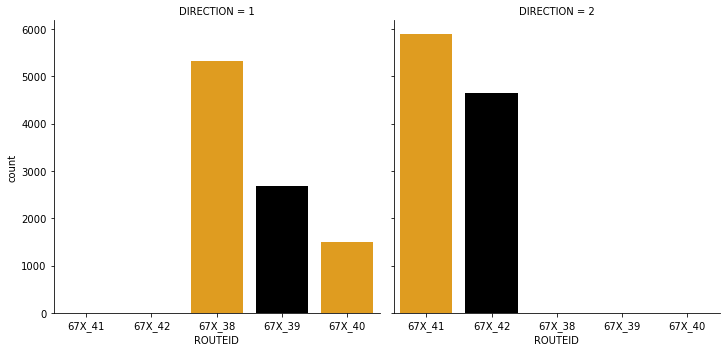

<Figure size 432x288 with 0 Axes>

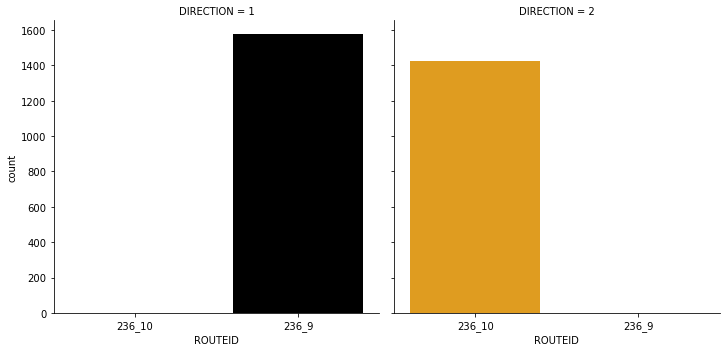

<Figure size 432x288 with 0 Axes>

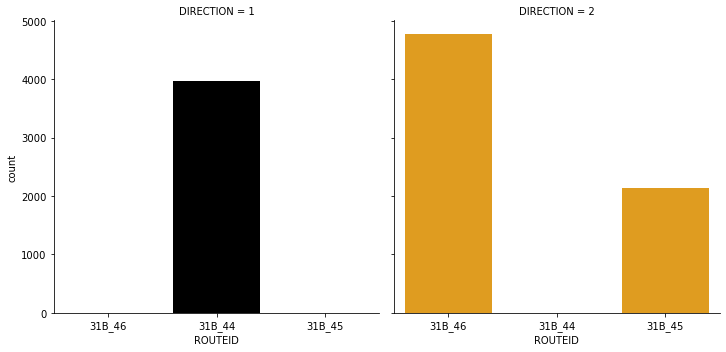

<Figure size 432x288 with 0 Axes>

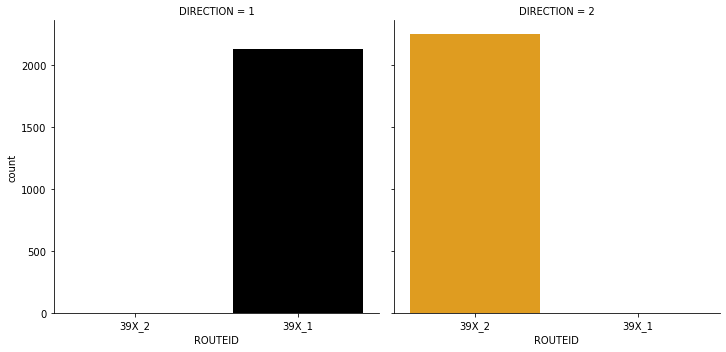

<Figure size 432x288 with 0 Axes>

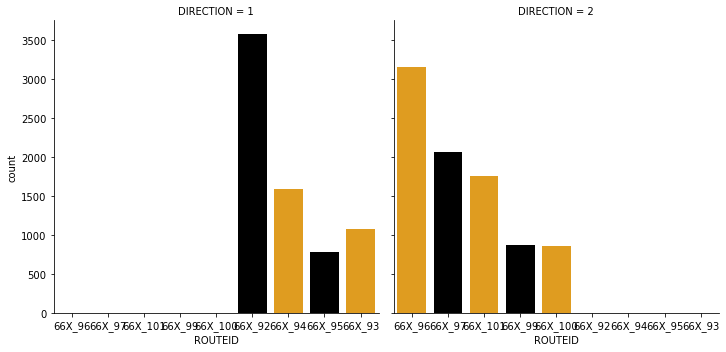

<Figure size 432x288 with 0 Axes>

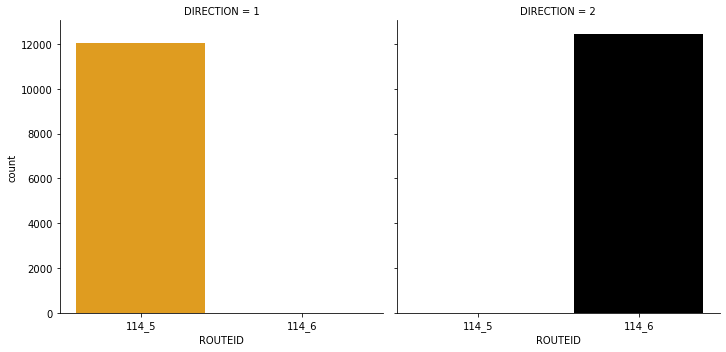

<Figure size 432x288 with 0 Axes>

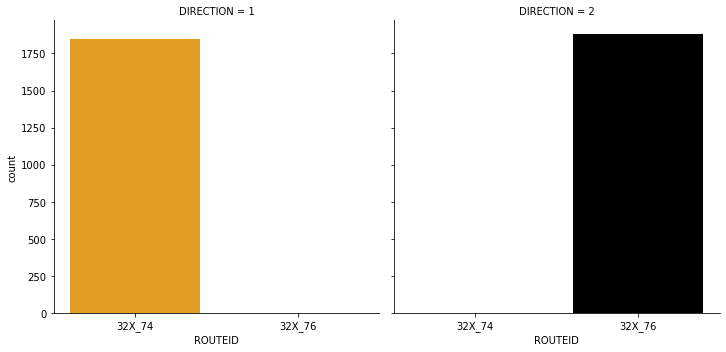

<Figure size 432x288 with 0 Axes>

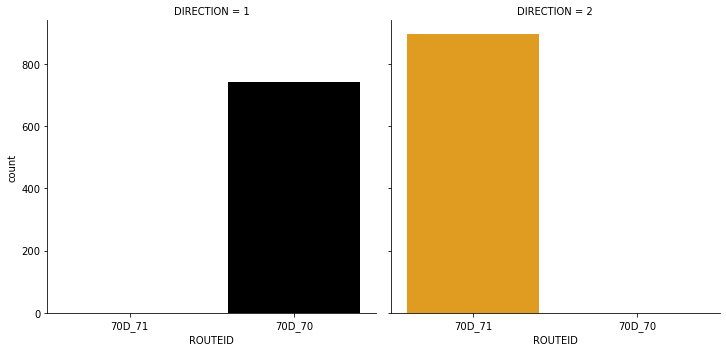

<Figure size 432x288 with 0 Axes>

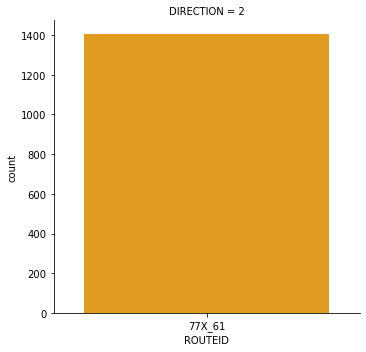

<Figure size 432x288 with 0 Axes>

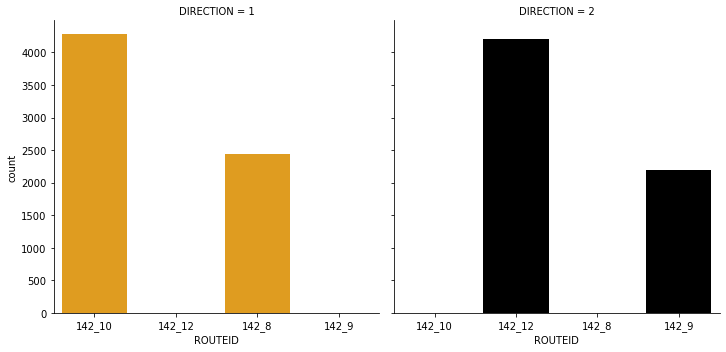

<Figure size 432x288 with 0 Axes>

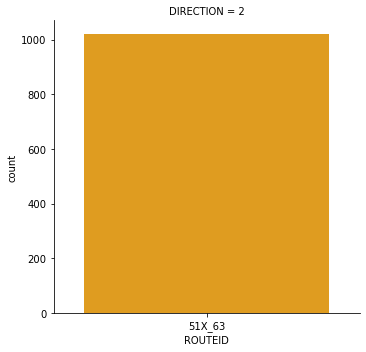

<Figure size 432x288 with 0 Axes>

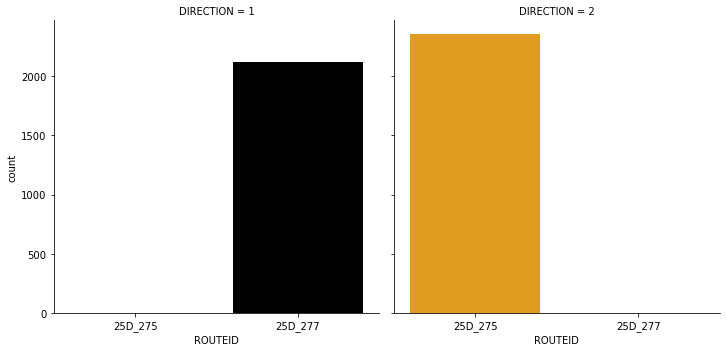

<Figure size 432x288 with 0 Axes>

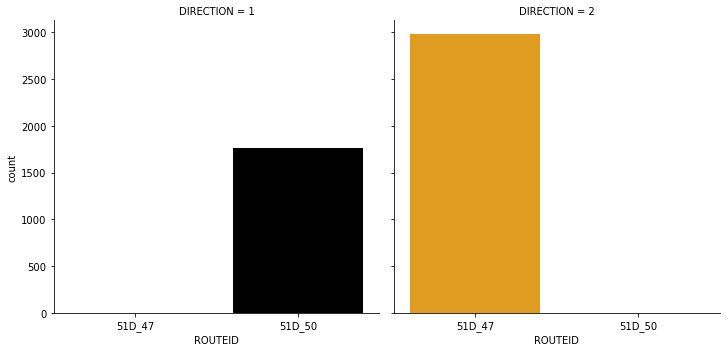

<Figure size 432x288 with 0 Axes>

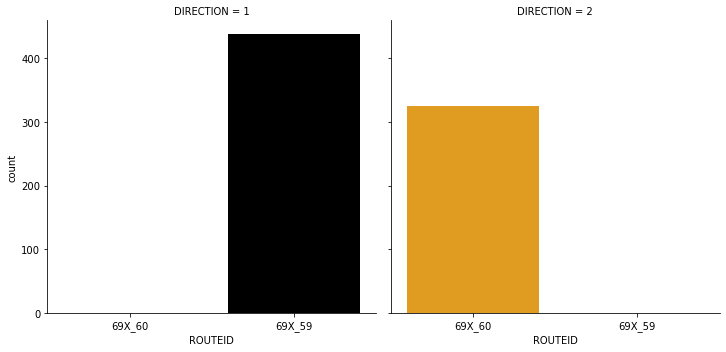

<Figure size 432x288 with 0 Axes>

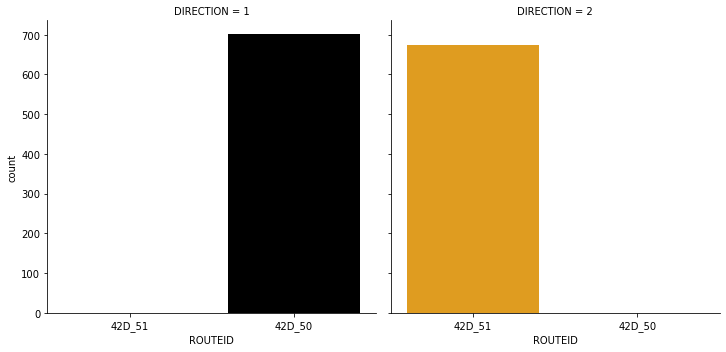

<Figure size 432x288 with 0 Axes>

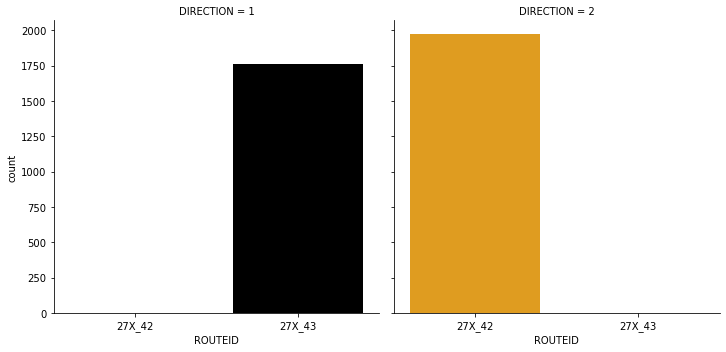

<Figure size 432x288 with 0 Axes>

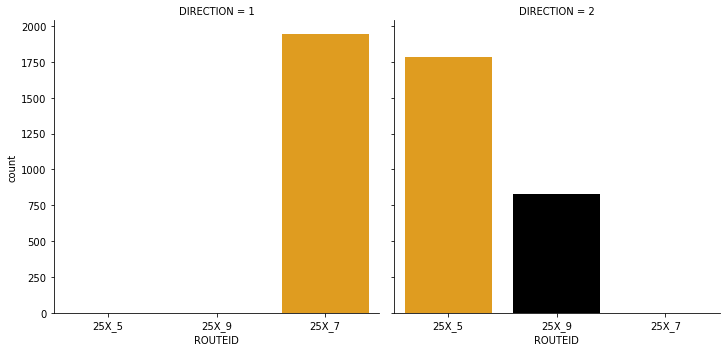

<Figure size 432x288 with 0 Axes>

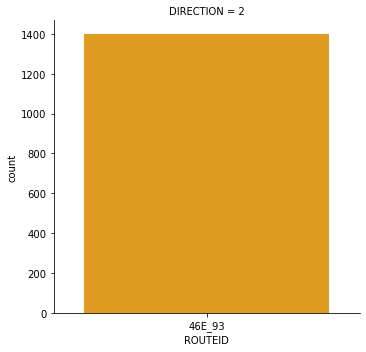

<Figure size 432x288 with 0 Axes>

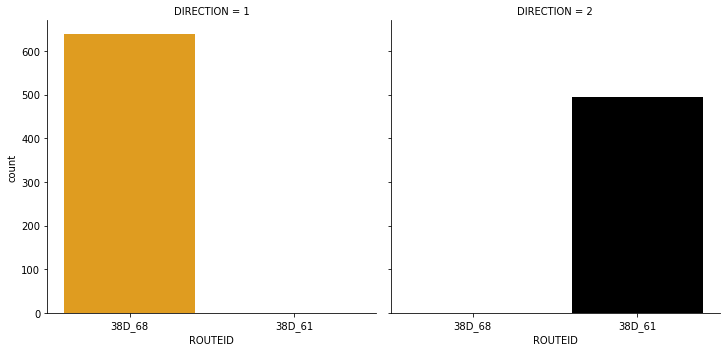

<Figure size 432x288 with 0 Axes>

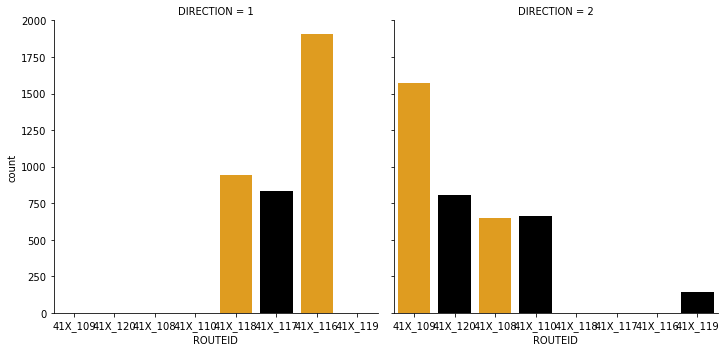

<Figure size 432x288 with 0 Axes>

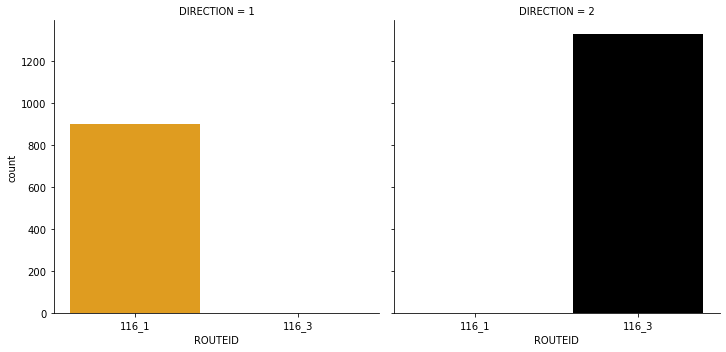

<Figure size 432x288 with 0 Axes>

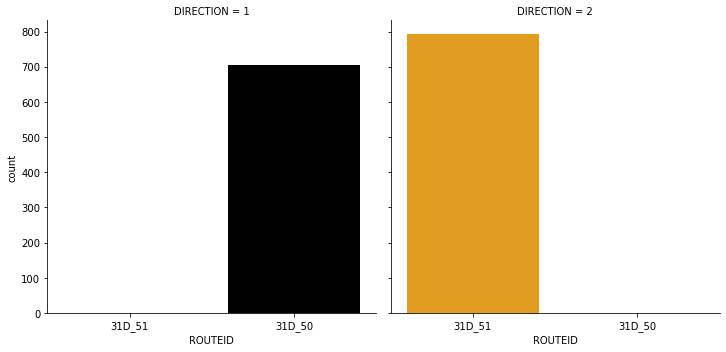

<Figure size 432x288 with 0 Axes>

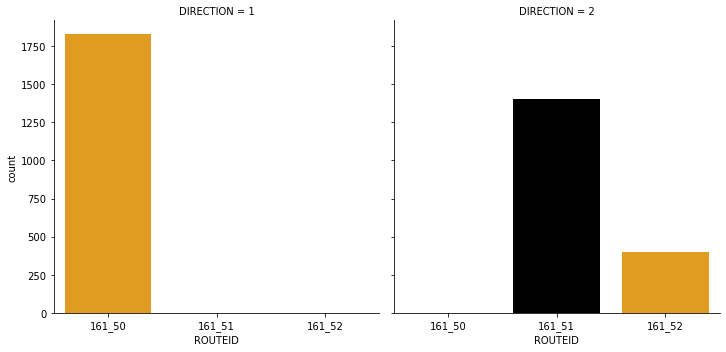

<Figure size 432x288 with 0 Axes>

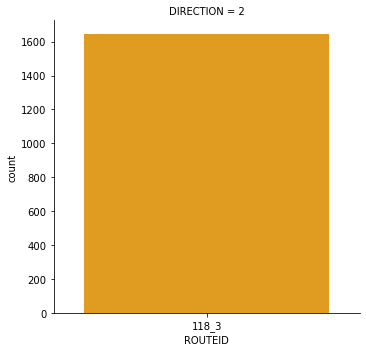

<Figure size 432x288 with 0 Axes>

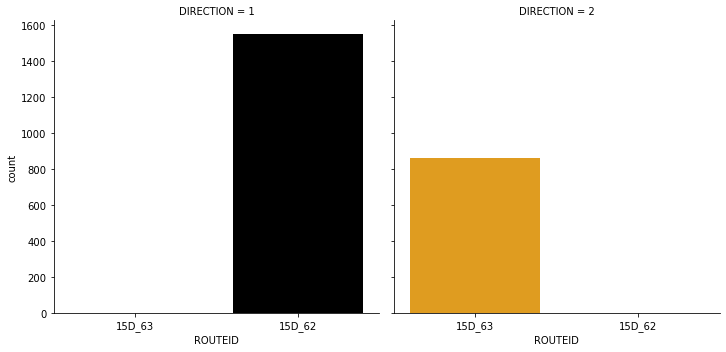

<Figure size 432x288 with 0 Axes>

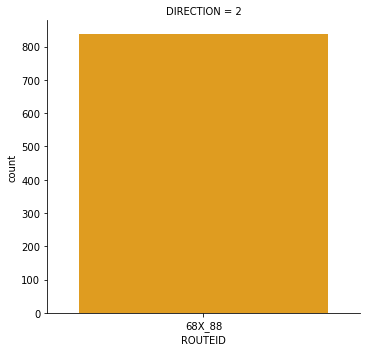

<Figure size 432x288 with 0 Axes>

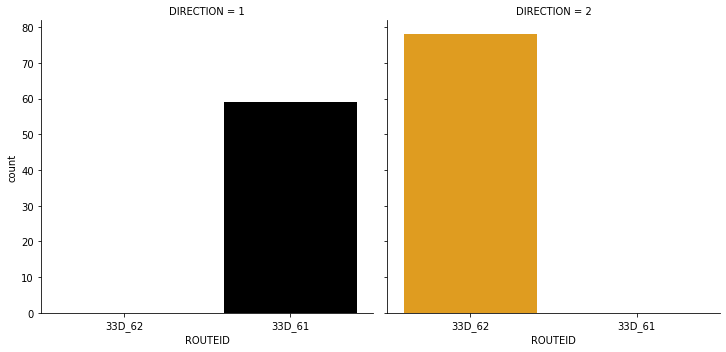

In [19]:
# plot counts of entries for ROUTEID of a particular LINEID

df_dominant_route = pd.DataFrame(columns=["DIRECTION","LINEID","ROUTEID"])
with PdfPages('../Reports/LINEID_Route_counts_JAN_data.pdf') as pp:
    for Line in list(df_Jan_trips.LINEID.unique()):
        
        # dataframe dominant_route is used to record dominant route for each LINEID
        df_line = df_Jan_trips.loc[df_Jan_trips["LINEID"] == Line]
        try:
            dom_route_D1 = df_line[(df_line["DIRECTION"] == 1)]["ROUTEID"].value_counts(sort=True).keys()[0]
            df_dominant_route.loc[len(df_dominant_route)] = [1,Line,dom_route_D1]
        except:
            print("error in line",Line,"direction 1")
        
        try:
            dom_route_D2 = df_line[(df_line["DIRECTION"] == 2)]["ROUTEID"].value_counts(sort=True).keys()[0]            
            df_dominant_route.loc[len(df_dominant_route)] = [2,Line,dom_route_D2]
        except:
            print("error in line",Line,"direction 2")
            
        plt.figure()
        sns.catplot(x="ROUTEID",col="DIRECTION",kind="count",palette=sns.color_palette(['orange', 'black']), \
                data=df_line)
        pp.savefig()


### Save dominant ROUTEIDs in a CSV

In [20]:
df_dominant_route.to_csv('../DB/dominant_route.csv', index=False)

### Release RAM used for prior dataframes

In [21]:
# release temporary dataframes from RAM
del dom_route_D1
del dom_route_D2
del df_dominant_route

### Generate merged month_trip file only with dominant ROUTE

In [22]:
df_dominant_route_list = pd.read_csv('../DB/dominant_route.csv')
dominant_route_list = list(df_dominant_route_list["ROUTEID"])
df_Jan_trips_dom_Route = df_Jan_trips.loc[df_Jan_trips['ROUTEID'].isin(dominant_route_list)]

In [23]:
print("Shape of dataframe",df_Jan_trips_dom_Route.shape)
df_Jan_trips_dom_Route.head()

Shape of dataframe (9473485, 11)


,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
0,2018-01-01,5958355,3,1172,23799,23799,23863,23863,41,1,41_3
1,2018-01-01,5958355,4,1173,23860,23860,23934,24072,41,1,41_3
2,2018-01-01,5958355,5,1174,23937,23937,24114,24140,41,1,41_3
3,2018-01-01,5958355,6,1175,24048,24048,24180,24192,41,1,41_3
4,2018-01-01,5958355,7,15,24130,24130,24227,24257,41,1,41_3


### UNIQUE ENTRIES

In [24]:
df_Jan_trips_dom_Route.nunique()

DAYOFSERVICE          31
TRIPID             69359
PROGRNUMBER          102
STOPPOINTID         4516
PLANNEDTIME_ARR    67737
PLANNEDTIME_DEP    67737
ACTUALTIME_ARR     70065
ACTUALTIME_DEP     70063
LINEID               126
DIRECTION              2
ROUTEID              246
dtype: int64

$\Large Analysis\ of\ sample\ size\ after\ dropping\ data$
* **COUNT OF ENTRIES FOR ORIGINAL DATA df_Jan_trips = $10389094$ | with count of ROUTEIDs = $498$**
* **COUNT OF ENTRIES FOR ORIGINAL DATA AFTER OMMITING NON SIGNIFICANT ROUTEIDS = $9473485$ | with count of ROUTEIDs = $246$**
* **AFTER DROPPING DATA FOR NON SIGNIFICANT ROUTEIDS [which are roughly $50\%$ of total ROUTEIDs]; WE ARE STILL LEFT WITH $\Large 91\%$ OF DATA (9473485/10389094 * 100)**
<br>

**THIS IS SIGNIFICANT SIZE OF DATA SIZE TO TRAIN ON; AS WE HAVE REDUCED CARDINALITY OF ROUTEID FEATURE BY $50\%$ LOOSING ONLY $9\%$ OF DATA**

#### Save data to csv

In [25]:
df_Jan_trips_dom_Route.to_csv("../DB/ML/imp_ROUTEID_Jan_trips_MERGED.csv",index=False)

### Release RAM used for prior dataframes

In [26]:
del df_Jan_trips

<br>
<br>

## Dataframe for model training
**dataframe necessary To train a prediction Model for Target variable "ACTUALTIME_ARR" is obtained in this section**

**OPERATIONS DONE TO THIS STAGE** <br>
* **OBTAIN currently opearting STOPPOINTIDs [list obtained by RTPI API scrping]**
* **MERGE January leavetimes data on trips data**
* **FILTER it for currently opearting STOPPOINTIDs only [list obtained by RTPI API scrping]**
* **OBTAIN list of dominant ROUTEIDs by analysing this merged data**
* **FILTER on these dominant ROUTEIDs**

In [27]:
## Uncomment and Run to start operation from current section

# df_Jan_trips_dom_Route = pd.read_csv("../DB/ML/imp_ROUTEID_Jan_trips_MERGED.csv")

# df_Jan_trips_dom_Route['DAYOFSERVICE'] = pd.to_datetime(df_Jan_trips_dom_Route['DAYOFSERVICE'])
# df_Jan_trips_dom_Route['TRIPID'] = pd.to_numeric(df_Jan_trips_dom_Route['TRIPID'], downcast='integer', errors='coerce')
# df_Jan_trips_dom_Route['PROGRNUMBER'] = pd.to_numeric(df_Jan_trips_dom_Route['PROGRNUMBER'], downcast='integer', errors='coerce')
# df_Jan_trips_dom_Route['STOPPOINTID'] = pd.to_numeric(df_Jan_trips_dom_Route['STOPPOINTID'], downcast='integer', errors='coerce')
# df_Jan_trips_dom_Route['PLANNEDTIME_ARR'] = pd.to_numeric(df_Jan_trips_dom_Route['PLANNEDTIME_ARR'], downcast='integer', errors='coerce')
# df_Jan_trips_dom_Route['ACTUALTIME_ARR'] = pd.to_numeric(df_Jan_trips_dom_Route['ACTUALTIME_ARR'], downcast='integer', errors='coerce')
# df_Jan_trips_dom_Route['ACTUALTIME_DEP'] = pd.to_numeric(df_Jan_trips_dom_Route['ACTUALTIME_DEP'], downcast='integer', errors='coerce')
# df_Jan_trips_dom_Route['LINEID'] = df_Jan_trips_dom_Route['LINEID'].astype('str')
# df_Jan_trips_dom_Route['ROUTEID'] = df_Jan_trips_dom_Route['ROUTEID'].astype('str')
# df_Jan_trips_dom_Route['DIRECTION'] = pd.to_numeric(df_Jan_trips_dom_Route['DIRECTION'], downcast='integer', errors='coerce')

### Resolve datetime parameter

In [28]:
df_Jan_trips_dom_Route['year'] = df_Jan_trips_dom_Route.DAYOFSERVICE.dt.year 
df_Jan_trips_dom_Route['month'] = df_Jan_trips_dom_Route.DAYOFSERVICE.dt.month
df_Jan_trips_dom_Route['dayofweek_num']=df_Jan_trips_dom_Route.DAYOFSERVICE.dt.dayofweek 
df_Jan_trips_dom_Route['quarter']=df_Jan_trips_dom_Route.DAYOFSERVICE.dt.quarter 

### dataframe To train a prediction Model for Target variable "ACTUALTIME_ARR"

In [29]:
df_Jan_trips_arr = df_Jan_trips_dom_Route[["year","month","dayofweek_num","quarter","LINEID","DIRECTION","STOPPOINTID","PROGRNUMBER","PLANNEDTIME_ARR","ACTUALTIME_ARR"]]

In [30]:
print("Shape of dataframe",df_Jan_trips_arr.shape)
df_Jan_trips_arr.head()

Shape of dataframe (9473485, 10)


,year,month,dayofweek_num,quarter,LINEID,DIRECTION,STOPPOINTID,PROGRNUMBER,PLANNEDTIME_ARR,ACTUALTIME_ARR
0,2018,1,0,1,41,1,1172,3,23799,23863
1,2018,1,0,1,41,1,1173,4,23860,23934
2,2018,1,0,1,41,1,1174,5,23937,24114
3,2018,1,0,1,41,1,1175,6,24048,24180
4,2018,1,0,1,41,1,15,7,24130,24227


#### UNIQUE ENTRIES

In [31]:
df_Jan_trips_arr.nunique()

year                   1
month                  1
dayofweek_num          7
quarter                1
LINEID               126
DIRECTION              2
STOPPOINTID         4516
PROGRNUMBER          102
PLANNEDTIME_ARR    67737
ACTUALTIME_ARR     70065
dtype: int64

#### Save dataframe to csv

In [32]:
df_Jan_trips_arr.to_csv("../DB/ML/Jan_Trips_arr.csv",index=False)

### Release RAM used for prior dataframes

In [33]:
del df_Jan_trips_dom_Route

<br>
<br>

## Generate dataframe with MINUTES resolution for PLANNEDTIME_ARR and ACTUALTIME_ARR

### Read copy of df_Jan_trips_arr.csv

In [34]:
## Uncomment and Run to start operation from current section

# df_Jan_trips_arr_MINUTES = pd.read_csv("../DB/ML/Jan_Trips_arr.csv")

# df_Jan_trips_arr_MINUTES['year'] = df_Jan_trips_arr_MINUTES['year'].astype('category')
# df_Jan_trips_arr_MINUTES['month'] = df_Jan_trips_arr_MINUTES['month'].astype('category')
# df_Jan_trips_arr_MINUTES['dayofweek_num'] = df_Jan_trips_arr_MINUTES['dayofweek_num'].astype('category')
# df_Jan_trips_arr_MINUTES['quarter'] = df_Jan_trips_arr_MINUTES['quarter'].astype('category')
# df_Jan_trips_arr_MINUTES['PROGRNUMBER'] = df_Jan_trips_arr_MINUTES['PROGRNUMBER'].astype('category')
# df_Jan_trips_arr_MINUTES['STOPPOINTID'] = df_Jan_trips_arr_MINUTES['STOPPOINTID'].astype('category')
# df_Jan_trips_arr_MINUTES['PLANNEDTIME_ARR'] = pd.to_numeric(df_Jan_trips_arr_MINUTES['PLANNEDTIME_ARR'], downcast='integer', errors='coerce')
# df_Jan_trips_arr_MINUTES['ACTUALTIME_ARR'] = pd.to_numeric(df_Jan_trips_arr_MINUTES['ACTUALTIME_ARR'], downcast='integer', errors='coerce')
# df_Jan_trips_arr_MINUTES['LINEID'] = df_Jan_trips_arr_MINUTES['LINEID'].astype('category')
# df_Jan_trips_arr_MINUTES['DIRECTION'] = df_Jan_trips_arr_MINUTES['DIRECTION'].astype('category')

In [35]:
df_Jan_trips_arr_MINUTES = df_Jan_trips_arr.copy()

In [36]:
print("Shape of dataframe",df_Jan_trips_arr_MINUTES.shape)
df_Jan_trips_arr_MINUTES.head()

Shape of dataframe (9473485, 10)


,year,month,dayofweek_num,quarter,LINEID,DIRECTION,STOPPOINTID,PROGRNUMBER,PLANNEDTIME_ARR,ACTUALTIME_ARR
0,2018,1,0,1,41,1,1172,3,23799,23863
1,2018,1,0,1,41,1,1173,4,23860,23934
2,2018,1,0,1,41,1,1174,5,23937,24114
3,2018,1,0,1,41,1,1175,6,24048,24180
4,2018,1,0,1,41,1,15,7,24130,24227


#### ROUND-OFF [FLOOR] PLANNEDTIME_ARR and ACTUALTIME_ARR TO MINUTE RESOLUTION
* **PLANNEDTIME_ARR and ACTUALTIME_ARR are in seconds resolution**
* **With these resolutions; earlier ML model gave RMSE of aproximately 300 seconds**
* **Flooring seconds data to minutes data would add worst case input error of 1 minute**
* **BUT AS OBSERVED BELLOW; IT REDUCES CARDINALITY OF BOTH FETURES SIGNIFICANTLY**

FOR JANUARY 2018 DATA:

|FEATURE|COUNT of unique entries(seconds)|COUNT of unique entries (minutes)|
|------|------|------|
|PLANNEDTIME_ARR  |67749  |1215  |
|ACTUALTIME_ARR  |70065  |1222 |


In [37]:
df_Jan_trips_arr_MINUTES['PLANNEDTIME_ARR'] = df_Jan_trips_arr_MINUTES['PLANNEDTIME_ARR'] - df_Jan_trips_arr_MINUTES['PLANNEDTIME_ARR'].mod(60)
df_Jan_trips_arr_MINUTES['ACTUALTIME_ARR'] = df_Jan_trips_arr_MINUTES['ACTUALTIME_ARR'] - df_Jan_trips_arr_MINUTES['ACTUALTIME_ARR'].mod(60)

df_Jan_trips_arr_MINUTES

,year,month,dayofweek_num,quarter,LINEID,DIRECTION,STOPPOINTID,PROGRNUMBER,PLANNEDTIME_ARR,ACTUALTIME_ARR
0,2018,1,0,1,41,1,1172,3,23760,23820
1,2018,1,0,1,41,1,1173,4,23820,23880
2,2018,1,0,1,41,1,1174,5,23880,24060
3,2018,1,0,1,41,1,1175,6,24000,24180
4,2018,1,0,1,41,1,15,7,24120,24180
...,...,...,...,...,...,...,...,...,...,...
10388804,2018,1,2,1,33B,1,3726,16,86760,86640
10388805,2018,1,2,1,33B,1,7039,17,86820,86640
10388806,2018,1,2,1,33B,1,7204,18,86880,86700
10388807,2018,1,2,1,33B,1,3728,19,86940,86820


#### UNIQUE ENTRIES

In [38]:
df_Jan_trips_arr_MINUTES.nunique()

year                  1
month                 1
dayofweek_num         7
quarter               1
LINEID              126
DIRECTION             2
STOPPOINTID        4516
PROGRNUMBER         102
PLANNEDTIME_ARR    1215
ACTUALTIME_ARR     1222
dtype: int64

#### Save csv

In [39]:
df_Jan_trips_arr_MINUTES.to_csv("../DB/ML/Jan_trips_arr_MINUTES.csv",index=False)

### Release RAM used for prior dataframes

In [40]:
del df_Jan_trips_arr

### ANALYSIS from prior EDA
* **Even after converting to minute resolution; number of unique entries for PLANNEDTIME_ARR exceed number of ferries made on a LINEID in a DIRECTION in a day**
* **Hence; NO FIXED TIMETABLE CAN BE DRAWN UP FOR A STOPOINTID SERVING LINEID**
<br>

**FACT**
* **Converting PLANNEDTIME_ARR to minute resolution reduces unique entries significantly. Also, it is way forward as front end shall provide ARRIVAL TIME input in terms of minutes**
<br>
<br>

**WE ARE CHOOSING TO PROCEED WITH THIS ANOMALY WHILE TRAINING AND USING MODEL AS:**
* **NO WAY AROUND CAN BE FOUND TO GET ARRIVALTIME TIMETABLE FOR EACH STOPOINTID FOR A LINEID of DUBLIN BUS**

<br>
<br>

## Generate planned arrival time TIMETABLE

In [41]:
## Uncomment and Run to start operation from current section

# df_Jan_trips_arr_MINUTES = pd.read_csv("../DB/ML/Jan_trips_arr_MINUTES.csv")

# df_Jan_trips_arr_MINUTES['LINEID'] = df_Jan_trips_arr_MINUTES['LINEID'].astype('category')
# df_Jan_trips_arr_MINUTES['DIRECTION'] = df_Jan_trips_arr_MINUTES['DIRECTION'].astype('category')
# df_Jan_trips_arr_MINUTES['STOPPOINTID'] = df_Jan_trips_arr_MINUTES['STOPPOINTID'].astype('category')
# df_Jan_trips_arr_MINUTES['PROGRNUMBER'] = df_Jan_trips_arr_MINUTES['PROGRNUMBER'].astype('category')
# df_Jan_trips_arr_MINUTES['PLANNEDTIME_ARR'] = pd.to_numeric(df_Jan_trips_arr_MINUTES['PLANNEDTIME_ARR'], downcast='integer', errors='coerce')

### Generate TIMETABLE
**UNIQUE ENTRIES FOR [LINEID, DIRECTION, STOPPOINTID, PROGRNUMBER, PLANNEDTIME_ARR] FORMS TIMETABLE**

In [42]:
df_Jan_trips_arr_TIMETABLE = df_Jan_trips_arr_MINUTES[['LINEID', 'DIRECTION', 'STOPPOINTID',\
                                                       'PROGRNUMBER', 'PLANNEDTIME_ARR']].drop_duplicates()
df_Jan_trips_arr_TIMETABLE

,LINEID,DIRECTION,STOPPOINTID,PROGRNUMBER,PLANNEDTIME_ARR
0,41,1,1172,3,23760
1,41,1,1173,4,23820
2,41,1,1174,5,23880
3,41,1,1175,6,24000
4,41,1,15,7,24120
...,...,...,...,...,...
10387506,111,1,3055,44,86400
10387507,111,1,3056,45,86400
10387508,111,1,3057,46,86460
10388772,184,1,6138,43,87300


In [43]:
df_Jan_trips_arr_TIMETABLE.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1535466 entries, 0 to 10388773
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   LINEID           1535466 non-null  object
 1   DIRECTION        1535466 non-null  int8  
 2   STOPPOINTID      1535466 non-null  int16 
 3   PROGRNUMBER      1535466 non-null  int8  
 4   PLANNEDTIME_ARR  1535466 non-null  int32 
dtypes: int16(1), int32(1), int8(2), object(1)
memory usage: 35.1+ MB


#### UNIQUE ENTRIES

In [44]:
df_Jan_trips_arr_TIMETABLE.nunique()

LINEID              126
DIRECTION             2
STOPPOINTID        4516
PROGRNUMBER         102
PLANNEDTIME_ARR    1215
dtype: int64

### Save csv

In [45]:
df_Jan_trips_arr_TIMETABLE.to_csv("../DB/ML/Jan_trips_arr_TIMETABLE.csv",index=False)

### Release RAM used for prior dataframes

In [46]:
del df_Jan_trips_arr_MINUTES

<br>
<br>

## Generate Meta Tables
**Jan_trips_arr_TIMETABLE.csv is sufficent for providing:**
* **Inputs to ML prediction model**
* **Necessary data for front end**

**THOUGH, QUERYING SUCH LARGE DATA EACH TIME FOR FRONT END APPLICATION CREATES LATENCY ISSUES**
* **HENCE, SOME REDUNDANT META TABLES ARE CREATED FOR QUICK ACCESS TO front end. IT INCLUDES :**

    * **lines_progr.CSV** : LINEID - DIRECTION - FIRST PROGRAM NUMBER - LAST PROGRAM NUMBER
    * **stop_lines_progr_dir.CSV** : LINEID - PROGRAM NUMBER - DIRECTION - STOPPOINTID

### Generate STOPS_LINES_PROGR_DIR.CSV

In [47]:
## Uncomment and Run to start operation from current section

# df_Jan_trips_arr_TIMETABLE = pd.read_csv("../DB/ML/Jan_trips_arr_TIMETABLE.csv")

# df_Jan_trips_arr_TIMETABLE['LINEID'] = df_Jan_trips_arr_TIMETABLE['LINEID'].astype('category')
# df_Jan_trips_arr_TIMETABLE['DIRECTION'] = df_Jan_trips_arr_TIMETABLE['DIRECTION'].astype('category')
# df_Jan_trips_arr_TIMETABLE['STOPPOINTID'] = df_Jan_trips_arr_TIMETABLE['STOPPOINTID'].astype('category')
# df_Jan_trips_arr_TIMETABLE['PROGRNUMBER'] = df_Jan_trips_arr_TIMETABLE['PROGRNUMBER'].astype('category')

In [48]:
df_STOPS_LINES_PROGR_DIR = df_Jan_trips_arr_TIMETABLE[['LINEID', 'DIRECTION', 'STOPPOINTID',\
                                                       'PROGRNUMBER']].drop_duplicates()

In [49]:
print("Shape of dataframe",df_STOPS_LINES_PROGR_DIR.shape)
df_STOPS_LINES_PROGR_DIR.head()

Shape of dataframe (12195, 4)


,LINEID,DIRECTION,STOPPOINTID,PROGRNUMBER
0,41,1,1172,3
1,41,1,1173,4
2,41,1,1174,5
3,41,1,1175,6
4,41,1,15,7


In [55]:
df_STOPS_LINES_PROGR_DIR.nunique()

LINEID          126
DIRECTION         2
STOPPOINTID    4516
PROGRNUMBER     102
dtype: int64

### Save csv

In [50]:
df_STOPS_LINES_PROGR_DIR.to_csv("../DB/stops_routes.csv",index=False)

### Generate LINES_PROGR.CSV

In [51]:
## Uncomment and Run to start operation from current section

# df_STOPS_LINES_PROGR_DIR = pd.read_csv("../DB/ML/Jan_trips_arr_TIMETABLE.csv")

# df_STOPS_LINES_PROGR_DIR = df_STOPS_LINES_PROGR_DIR[['LINEID', 'DIRECTION','PROGRNUMBER']].drop_duplicates()

# df_STOPS_LINES_PROGR_DIR['LINEID'] = df_STOPS_LINES_PROGR_DIR['LINEID'].astype('category')
# df_STOPS_LINES_PROGR_DIR['DIRECTION'] = df_STOPS_LINES_PROGR_DIR['DIRECTION'].astype('category')
# df_STOPS_LINES_PROGR_DIR['PROGRNUMBER'] = df_STOPS_LINES_PROGR_DIR['PROGRNUMBER'].astype('category')

In [52]:
# Define schema for target Dataframe
df_LINES_PROGR = pd.DataFrame(columns=['LINEID', 'DIRECTION','FIRST_PROGRNUMBER','LAST_PROGRNUMBER'])

# Take slice of df_STOPS_LINES_PROGR_DIR
df_LINES_PROGR_DIR = df_STOPS_LINES_PROGR_DIR[['LINEID', 'DIRECTION','PROGRNUMBER']].copy()

# group by Line and direction
group_LINES_PROGR_DIR = df_LINES_PROGR_DIR.groupby(['LINEID', 'DIRECTION'])['PROGRNUMBER']

for (line,direction),List_ProgrNum in group_LINES_PROGR_DIR:
    list_PROGR = sorted(List_ProgrNum.to_list())
    df_LINES_PROGR.loc[len(df_LINES_PROGR)] = [line,direction,list_PROGR[0],list_PROGR[-1]]

    # Generate data entry to meta  table
    df_LINES_PROGR.loc[len(df_LINES_PROGR)] = [line,direction,list_PROGR[0],list_PROGR[-1]]

df_LINES_PROGR.drop_duplicates(inplace = True)

In [53]:
print("Shape of dataframe",df_LINES_PROGR.shape)
df_LINES_PROGR.head()

Shape of dataframe (246, 4)


,LINEID,DIRECTION,FIRST_PROGRNUMBER,LAST_PROGRNUMBER
0,1,1,1,42
2,1,2,1,43
4,102,1,1,53
6,102,2,1,54
8,104,1,1,36


### Save csv

In [54]:
df_LINES_PROGR.to_csv("../DB/lines_progr.csv",index=False)